In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


### Storage Parameters

In [4]:
Ts = 1/12
c = 20
eta = 0.9
### For Intelligent Storage Ratio
# case_template = 'Strategic/VOLL5GWQuad/2022/UC25ED1_Strategic_true_ratio{}_Seg1_BAW0_MC20.0_hetefalse'
# case_template = 'Strategic/VOLL5GWLinear/2022/UC25ED1_Strategic_true_ratio{}_Seg1_BAW0_MC20.0_hetefalse'
# case_template = 'Strategic/PriceCap/2022_ED1_Strategic_true_FORB_true_ratio{}_Seg1_BAW0_Fuel2.0_NLC1.2_Error0.25NegativeRenew_1.0-2.0-2.0-2.0-2.0'
# case_template = 'Strategic/Exp1.2/2022/ED1_Strategic_true_FORB_true_ratio{}_Seg5_BAW0_1.0-2.0-2.0-2.0-2.0'
case_template = 'Strategic/Cases/20GW/ED1_Strategic_true_FORB_true_ratio{}_Seg1_BAW0_BSESCbid0.5'


ratios = [round(i * 0.1, 1) for i in range(11)]

### For random bidding model seletction
# case_template = 'Strategic/2022/UC25ED{}_Strategic_true_ratio1.0_Seg1_BAW0_MC20.0_hetefalse'
# ratios = [1, 6, 13]

### For Future Cases
# case_template = 'Strategic/{}/UC25ED1_Strategic_true_ratio1.0_Seg1_BAW0_MC20.0_hetefalse'
# ratios = [2022, 2030, 2040, 2050]

# case = 'Strategic/MC20/Strategic/UC25ED1_Strategic_true_ratio0.3_Seg1_BAW0_MC20.0'
# case = 'Strategic/UC25ED1_Strategic_true_Seg1_Load1.0_Fuel1.2_Error0.25_ratio1.0_MIP0.1_DARTDP_Hete'
# case = 'Strategic/BidAhead/UC25ED1_Strategic_true_Seg1_Load1.0_Fuel1.2_Error0.25_ratio1.0_MIP0.1_DARTDP_BAW36'

### Price Stats

In [ ]:
# Initialize lists to hold DataFrames
mean_prices_dfs = []
std_prices_dfs = []

In [ ]:
# Loop over ratios from 0.0 to 1.0 (assuming increment by 0.1)
for ratio in ratios:
    case = case_template.format(ratio)
    try:
        # Try to read the CSV file for the current case
        price = pd.read_csv('output/'+case+'/EDprice.csv', header=None)
    except FileNotFoundError:
        print(f"File for case {case} not found.")
        continue

    # Calculate stats and transpose
    pricestats = pd.concat([price.mean()*12, (price*12).std()], axis=1).T

    # Now, instead of appending Series objects, you create DataFrame slices for each and append them
    mean_prices_dfs.append(pricestats.iloc[[0]])
    std_prices_dfs.append(pricestats.iloc[[1]])

In [ ]:
# Convert lists of series to DataFrames
mean_prices_df = pd.concat(mean_prices_dfs).reset_index(drop=True)
std_prices_df = pd.concat(std_prices_dfs).reset_index(drop=True)
mean_prices_df.index = ratios
std_prices_df.index = ratios

In [ ]:
mean_prices_df

In [ ]:
std_prices_df

In [ ]:
# Assuming mean_prices_df and std_prices_df are already defined
# Selecting the columns for Regions 1, 2, and 3
regions = [0, 1, 2]
mean_prices = mean_prices_df.iloc[:, regions]
std_prices = std_prices_df.iloc[:, regions]

# Preparing ISR values from the index
isr_values = mean_prices.index

# New colors and error bar theme
new_colors = ['#0072B2', '#D55E00', '#CC79A7']  # Updated color palette
new_labels = ['Region 1 - 17MW', 'Region 2 - 3666MW', 'Region 3 - 1015MW']
line_styles = ['-', '--', '-.']  # Different line styles for visual distinction
marker_styles = ['o', 's', 'd']  # Different marker styles for each region
plt.figure(figsize=(10, 8))

for region, color, label, line_style, marker_style in zip(regions, new_colors, new_labels, line_styles, marker_styles):
    plt.errorbar(isr_values, mean_prices.iloc[:, region], yerr=std_prices.iloc[:, region], 
                 label=label, color=color, fmt=line_style + marker_style, capsize=5, elinewidth=2, capthick=2, markeredgewidth=2)

plt.title('CAISO Real-Time Price Variability by Region and ISR', fontsize=20)
plt.xlabel('Intelligent Storage Ratio (ISR)', fontsize=20)
plt.ylabel('Mean Price ($/MWh)', fontsize=20)
plt.ylim([0, 125])
plt.legend(fontsize=20, loc = 'upper right')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Setting tick parameters for both axes
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.tight_layout()

# Save the plot to a file suitable for inclusion in your paper
# plt.savefig('/mnt/data/caiso_price_variability.png', dpi=300)

# Show the plot
plt.show()


### Total System Cost & Avg SOC

In [ ]:
case_template = 'Strategic/Cases/5GW/ED1_Strategic_true_FORB_true_ratio{}_Seg1_BAW0_BSESCbid0.5'
ratios = [round(i * 0.1, 1) for i in range(11)]
# Capacity = 19573.6
Capacity = 39930.144
# Capacity = 59895.216
# Capacity = 79860.288

total_system_costs = []
# Loop over ratios from 0.0 to 1.0 (assuming increment by 0.1)
for ratio in ratios:
    case = case_template.format(ratio, ratio)
    try:
        # Read the CSV file for the current case
        cost = pd.read_csv(f'output/{case}/EDcost.csv', header=None)
        SOC = pd.read_csv(f'output/{case}/EDSOCini.csv', header=None)
    except FileNotFoundError:
        print(f"File for case {case} not found.")
        # Optionally, append a NaN or some indicator of missing data
        total_system_costs.append({
                'System Cost': float('nan'),
                'Average SoC': float('nan')
        })
        continue

    # Sum the total cost and normalize
    total_cost_normalized = cost.sum().values[0] / (10**10)
    if ratio == 0.0:
        avg_soc = SOC.iloc[:, -6:].sum().sum()/(Capacity*288*364)*100
#         avg_soc_bs = SOC.iloc[:, -6:].sum().sum()/(Capacity*288*364)*100
#         avg_soc_ai = float('nan')
    elif ratio == 1.0:
        avg_soc = SOC.iloc[:, -6:].sum().sum()/(Capacity*288*364)*100
#         avg_soc_bs = float('nan')
#         avg_soc_ai = SOC.iloc[:, -6:].sum().sum()/(Capacity*288*364)*100
    else:
        avg_soc = SOC.iloc[:, -12:].sum().sum()/(Capacity*288*364)*100
#         avg_soc_bs = SOC.iloc[:, -11::2].sum().sum()/(Capacity*288*364*(1-ratio))*100
#         avg_soc_ai = SOC.iloc[:, -12::2].sum().sum()/(Capacity*288*364*ratio)*100
    total_system_costs.append({
                'Total System Cost': total_cost_normalized,
                'Average System SoC': avg_soc,
#                 'Average BS-ES SoC': avg_soc_bs,
#                 'Average AI-ES SoC': avg_soc_ai,       
        })
# Convert the list to a DataFrame
total_system_costs_df = pd.DataFrame(total_system_costs, columns=['Total System Cost','Average System SoC'])
# total_system_costs_df = pd.DataFrame(total_system_costs, columns=['Total System Cost','Average BS-ES SoC','Average AI-ES SoC'])

# Adjust the index to represent ratios directly, if desired
# total_system_costs_df.index = [str(round(i * 0.1, 1)) for i in range(11)]
total_system_costs_df.index = ratios


total_system_costs_df

In [ ]:
case_template = 'Strategic/5GW_C/ED1_Strategic_true_FORB_true_ratio{}_Seg5_BAW0_BSESCbid0.5'
ratios = [round(i * 0.1, 1) for i in range(11)]
total_system_costs = []
# Loop over ratios from 0.0 to 1.0 (assuming increment by 0.1)
for ratio in ratios:
    case = case_template.format(ratio, ratio)
    try:
        # Read the CSV file for the current case
        cost = pd.read_csv(f'output/{case}/EDcost.csv', header=None)
        SOC = pd.read_csv(f'output/{case}/EDSOCini.csv', header=None)
    except FileNotFoundError:
        print(f"File for case {case} not found.")
        # Optionally, append a NaN or some indicator of missing data
        total_system_costs.append({
                'System Cost': float('nan'),
                'Average SoC': float('nan')
        })
        continue

    # Sum the total cost and normalize
    total_cost_normalized = cost.sum().values[0] / (10**10)
    if ratio == 0.0:
        avg_soc = SOC.iloc[:, -6:].sum().sum()/(Capacity*288*364)*100
#         avg_soc_bs = SOC.iloc[:, -6:].sum().sum()/(Capacity*288*364)*100
#         avg_soc_ai = float('nan')
    elif ratio == 1.0:
        avg_soc = SOC.iloc[:, -6:].sum().sum()/(Capacity*288*364)*100
#         avg_soc_bs = float('nan')
#         avg_soc_ai = SOC.iloc[:, -6:].sum().sum()/(Capacity*288*364)*100
    else:
        avg_soc = SOC.iloc[:, -12:].sum().sum()/(Capacity*288*364)*100
#         avg_soc_bs = SOC.iloc[:, -11::2].sum().sum()/(Capacity*288*364*(1-ratio))*100
#         avg_soc_ai = SOC.iloc[:, -12::2].sum().sum()/(Capacity*288*364*ratio)*100
    total_system_costs.append({
                'Total System Cost': total_cost_normalized,
                'Average System SoC': avg_soc,
#                 'Average BS-ES SoC': avg_soc_bs,
#                 'Average AI-ES SoC': avg_soc_ai,       
        })
# Convert the list to a DataFrame
total_system_costs_df2 = pd.DataFrame(total_system_costs, columns=['Total System Cost','Average System SoC'])
# total_system_costs_df = pd.DataFrame(total_system_costs, columns=['Total System Cost','Average BS-ES SoC','Average AI-ES SoC'])

# Adjust the index to represent ratios directly, if desired
# total_system_costs_df.index = [str(round(i * 0.1, 1)) for i in range(11)]
total_system_costs_df2.index = ratios


total_system_costs_df2

In [ ]:
# Define ratios (x-axis values)
ratios = [round(i * 0.1, 1) for i in range(11)]

# Assuming total_system_costs_df and total_system_costs_df2 are already defined
# Calculate percentage reduction compared to 0.0 ISR
initial_cost1 = total_system_costs_df['Total System Cost'].iloc[0]
initial_cost2 = total_system_costs_df2['Total System Cost'].iloc[0]

percentage_reduction1 = (total_system_costs_df['Total System Cost'] - initial_cost1) / initial_cost1 * 100
percentage_reduction2 = (total_system_costs_df2['Total System Cost'] - initial_cost2) / initial_cost2 * 100

# Define bar width and bar positions
bar_width = 0.4
bar_positions1 = np.arange(len(ratios))
bar_positions2 = bar_positions1 + bar_width

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 7))

# Plot total system costs
color1 = '#0072B2'
color2 = '#009E73'
ax1.set_xlabel('Intelligent Storage Ratio (ISR)', fontsize=20)
ax1.set_ylabel('Total System Cost (Billion $)', fontsize=20)
bar1 = ax1.bar(bar_positions1, total_system_costs_df['Total System Cost'], width=bar_width, color=color1, alpha=0.6, label='Total System Cost - SoC-Independent')
bar2 = ax1.bar(bar_positions2, total_system_costs_df2['Total System Cost'], width=bar_width, color=color2, alpha=0.6, label='Total System Cost - SoC-Dependent')
ax1.tick_params(axis='y', labelsize=20)
ax1.tick_params(axis='x', labelsize=20)
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)
ax1.set_ylim([1.32, 1.40])

# Instantiate a second y-axis for percentage reduction
ax2 = ax1.twinx()
ax2.set_ylabel('Average System BESS SoC (%)', fontsize=20)

# Plot percentage reductions
line1, = ax2.plot(bar_positions1 + bar_width / 2, total_system_costs_df['Average System SoC'], '-o', color=color1, label='Average System SoC - SoC-Independent')
line2, = ax2.plot(bar_positions1 + bar_width / 2, total_system_costs_df2['Average System SoC'], '-o', color=color2, label='Average System SoC - SoC-Dependent')
# line1, = ax2.plot(bar_positions1 + bar_width / 2, total_system_costs_df['Average BS-ES SoC'], '-o', color=color1, label='Average BS-ES SoC - SoC-Independent')
# line2, = ax2.plot(bar_positions1 + bar_width / 2, total_system_costs_df2['Average BS-ES SoC'], '-o', color=color2, label='Average BS-ES SoC - SoC-Dependent')
# line3, = ax2.plot(bar_positions1 + bar_width / 2, total_system_costs_df['Average AI-ES SoC'], '-s', color=color1, label='Average AI-ES SoC - SoC-Independent')
# line4, = ax2.plot(bar_positions1 + bar_width / 2, total_system_costs_df2['Average AI-ES SoC'], '-s', color=color2, label='Average AI-ES SoC - SoC-Dependent')
ax2.tick_params(axis='y', labelsize=20)
ax2.set_ylim([0,100])

# Set x-axis ticks to be in the middle of the grouped bars
ax1.set_xticks(bar_positions1 + bar_width / 2)
ax1.set_xticklabels(ratios, fontsize=20)

# Combine legends from both axes
lines = [line1, line2]
# lines = [line1, line2, line3, line4]
bars = [bar1, bar2]
# ax1.legend(bars + lines, [bar.get_label() for bar in bars] + [line.get_label() for line in lines], loc='upper right', fontsize=20)

fig.tight_layout()
plt.title('Total System Cost and Average BESS SoC Across WECC vs ISR', fontsize=20)
plt.show()

In [ ]:
# Calculate percentage reduction compared to 0.0 ISR
initial_cost = total_system_costs_df['Total System Cost'].iloc[0]
percentage_reduction = (total_system_costs_df['Total System Cost'] - initial_cost) / initial_cost * 100

# Plotting
fig, ax1 = plt.subplots(figsize=(8, 6))

color = '#0072B2'
ax1.set_xlabel('Intelligent Storage Ratio (ISR)', fontsize=12)
ax1.set_ylabel('Total System Cost (Billion $)', color=color, fontsize=12)
ax1.bar(ratios, total_system_costs_df['Total System Cost'], width=0.05, color=color, alpha=0.6, label='Percentage Reduction')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)
ax1.set_ylim([1.35,1.41])

# Instantiate a second y-axis for average system BESS SoC
ax2 = ax1.twinx() 
color = '#D55E00'
ax2.set_ylabel('Average System BESS SoC (%)', color=color, fontsize=12)  
ax2.plot(ratios, total_system_costs_df['Average SoC'], '-o', color=color, label='Total System Cost')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim([40,65])


# Instantiate a second y-axis for percentage reduction
# ax2 = ax1.twinx() 
# color = '#D55E00'
# ax2.set_ylabel('Percentage Reduction (%)', color=color, fontsize=12)  
# ax2.bar(ratios, percentage_reduction, width=0.05, color=color, alpha=0.6, label='Percentage Reduction')
# ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  
plt.title('Total System Cost and Percentage Reduction Across WECC vs ISR', fontsize=14)
plt.show()

In [ ]:
# Calculate percentage reduction compared to 0.0 ISR
initial_cost = total_system_costs_df2['Total System Cost'].iloc[0]
percentage_reduction = (total_system_costs_df2['Total System Cost'] - initial_cost) / initial_cost * 100

# Plotting
fig, ax1 = plt.subplots(figsize=(8, 6))

color = '#0072B2'
ax1.set_xlabel('Intelligent Storage Ratio (ISR)', fontsize=12)
ax1.set_ylabel('Total System Cost (Billion $)', color=color, fontsize=12)
ax1.bar(ratios, total_system_costs_df['Total System Cost'], width=0.05, color=color, alpha=0.6, label='Percentage Reduction')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)
ax1.set_ylim([1.35,1.41])

# Instantiate a second y-axis for average system BESS SoC
ax2 = ax1.twinx() 
color = '#D55E00'
ax2.set_ylabel('Average System BESS SoC (%)', color=color, fontsize=12)  
ax2.plot(ratios, total_system_costs_df['Average SoC'], '-o', color=color, label='Total System Cost')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim([40,65])


# Instantiate a second y-axis for percentage reduction
# ax2 = ax1.twinx() 
# color = '#D55E00'
# ax2.set_ylabel('Percentage Reduction (%)', color=color, fontsize=12)  
# ax2.bar(ratios, percentage_reduction, width=0.05, color=color, alpha=0.6, label='Percentage Reduction')
# ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  
plt.title('Total System Cost and Percentage Reduction Across WECC vs ISR', fontsize=14)
plt.show()

### Loss of Load

In [ ]:
LL = pd.DataFrame(index=np.arange(0.0, 1.1, 0.1))

In [ ]:
cratios = [round(i * 0.1, 1) for i in range(11)]
case_name = 'SOC-Independent'

In [ ]:
case_template = 'Strategic/Cases/20GW/ED1_Strategic_true_FORB_true_ratio{}_Seg5_BAW0_BSESCbid0.5'
ratios = [round(i * 0.1, 1) for i in range(11)]
case_name = 'SOC-Dependent'

In [ ]:
total_system_ll = []
# Loop over ratios from 0.0 to 1.0 (assuming increment by 0.1)
for ratio in ratios:
    case = case_template.format(ratio, ratio)
    try:
        # Read the CSV file for the current case
        ll = pd.read_csv(f'output/{case}/EDSlack.csv', header=None)
    except FileNotFoundError:
        print(f"File for case {case} not found.")
        # Optionally, append a NaN or some indicator of missing data
        total_system_ll.append(float('nan'))
        continue

    # Sum the total ll
    total_ll = ll.sum().sum()/12
    total_system_ll.append(total_ll)
total_system_ll  

In [ ]:
LL[case_name] = total_system_ll
LL

In [ ]:
case_names = LL.columns
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(LL.index))  # the label locations
width = 0.2  # the width of the bars
fontsize = 20
# Define colors for related cases
colors = ['#1f77b4', '#ff7f0e', '#aec7e8', '#ffbb78']  # Dark and light shades of blue and orange

for i, name in enumerate(case_names):
    ax.bar(x + i*width - width*1.5, LL[name]/12, width, label=name, color=colors[i])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Intelligent Storage Ratio (ISR)', fontsize=fontsize)
ax.set_ylabel('Total Loss of Load (MWh)', fontsize=fontsize)
ax.set_title('Year-long Loss of Load by ISR and ES model', fontsize=fontsize)
ax.set_xticks(x)
ax.set_xticklabels([f"{label:.1f}" for label in LL.index], fontsize=fontsize)
ax.tick_params(axis='y', labelsize=fontsize)
ax.legend(fontsize=fontsize, title_fontsize=fontsize)

# Beautify the plot
plt.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
plt.tight_layout()

plt.show()

### Storage Profit & Utilization (Aggregated ISR 0.1-0.9)

In [33]:
ESID

38

In [40]:
(ESD[ESID-1]-ESC[ESID-1]).iloc[:, 0].max()

366.55250000000007

In [71]:
ESD.iloc[:,-1]

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
104827    0.0
104828    0.0
104829    0.0
104830    0.0
104831    0.0
Name: 47, Length: 104832, dtype: float64

In [74]:
case_template = 'Strategic/5GW_C/ED1_Strategic_true_FORB_true_ratio{}_Seg5_BAW0_BSESCbid0.5'

ratios = [round(i * 0.1+0.1, 1) for i in range(10)]
region = 2

# Initialize an empty list to store results
results = []

# Loop over ratios from 0.0 to 1.0 (assuming increment by 0.1)
for ratio in ratios:
    if (ratio <= 0.9) & (ratio >=0.1):
        case = case_template.format(ratio)
        try:
            # Try to read the CSV file for the current case
            ESD = pd.read_csv('output/'+case+'/EDESD.csv',header=None)
            ESC = pd.read_csv('output/'+case+'/EDESC.csv',header=None)
            price = pd.read_csv('output/'+case+'/EDprice.csv',header=None)
            ESindex = pd.read_csv('output/'+case+'/Strategic/storage_to_index_map.csv')
            ES = pd.read_csv('output/'+case+'/Strategic/ADDED_ES.csv')
        except FileNotFoundError:
            print(f"File for case {case} not found.")
            continue

        ESID = ESindex[ESindex['Region']==region]['StorageID'][1]
        i = region -1
        AIRevenue = sum((ESD-ESC).iloc[:,ESID-1]*price[i])/1000
        BSRevenue = sum((ESD-ESC).iloc[:,ESID]*price[i])/1000
        CTRevenue = sum((ESD-ESC).iloc[:,-1]*price[i])/1000
        AIProfit = AIRevenue - sum(Ts*c*ESD[ESID-1])/1000
        BSProfit = BSRevenue - sum(Ts*c*ESD[ESID])/1000
        CTProfit = CTRevenue - sum(Ts*c*ESD.iloc[:,-1])/1000
        AIUnitProfit = AIProfit/ES['EPD'][2*i]
        BSUnitProfit = BSProfit/ES['EPD'][2*i+1]
        CTUnitProfit = CTProfit
        AICycle = sum(ESD[ESID-1])/eta*Ts/ES['ESOC'][2*i]
        BSCycle = sum(ESD[ESID])/eta*Ts/ES['ESOC'][2*i+1]
        CTCycle = sum(ESD.iloc[:,-1])/eta*Ts/4
        
        # Append results to list
        results.append({
            'Ratio': ratio,
            'AIRevenue': AIRevenue,
            'BSRevenue': BSRevenue,
            'CTRevenue': CTRevenue,
            'AIProfit': AIProfit,
            'BSProfit': BSProfit,
            'CTProfit': CTProfit,
            'AIUnitProfit': AIUnitProfit,
            'BSUnitProfit': BSUnitProfit,
            'CTUnitProfit': CTUnitProfit,
            'AICycle': AICycle,
            'BSCycle': BSCycle,
            'CTCycle': CTCycle
        })

# Convert list of dictionaries to DataFrame
results_df = pd.DataFrame(results)
results_df
#     AIRevenue = sum((ESD[35]-ESC[35])*price[0])/1000

#     # Calculate stats and transpose
#     pricestats = pd.concat([price.mean()*12, (price*12).std()], axis=1).T

#     # Now, instead of appending Series objects, you create DataFrame slices for each and append them
#     mean_prices_dfs.append(pricestats.iloc[[0]])
#     std_prices_dfs.append(pricestats.iloc[[1]])

# case = 'Strategic/Exp/2022/UC25ED1_Strategic_true_FORB_true_ratio0.1_Seg1_BAW0_Fuel2.0_NLC2.0_Error0.25_ESPeakBidAdjustment1.0_ESPeakBid100.0NegativeRenew_1.0-2.0-2.0-2.0-2.0'

# ESD = pd.read_csv('output/'+case+'/EDESD.csv',header=None)
# ESC = pd.read_csv('output/'+case+'/EDESC.csv',header=None)
# price = pd.read_csv('output/'+case+'/EDprice.csv',header=None)
# ESindex = pd.read_csv('output/'+case+'/Strategic/storage_to_index_map.csv')
# ES = pd.read_csv('output/'+case+'/Strategic/ADDED_ES.csv')


,Ratio,AIRevenue,BSRevenue,CTRevenue,AIProfit,BSProfit,CTProfit,AIUnitProfit,BSUnitProfit,CTUnitProfit,AICycle,BSCycle,CTCycle
0,0.1,29584.403451,33339.615586,82.618385,21400.311133,15602.327142,59.436621,58.382663,4.729451,59.436621,310.100051,74.675139,321.968943
1,0.2,52044.610478,26433.237249,74.187221,36071.288091,11256.786109,51.116531,49.203440,3.838736,51.116531,302.619270,71.880578,320.426253
2,0.3,68551.073458,21371.298969,66.987961,45148.969748,8699.635252,44.119578,41.057302,3.390524,44.119578,295.573138,68.590966,317.616431
3,0.4,80075.761243,18100.456623,60.677474,49610.574142,7565.111441,38.015966,33.835927,3.439758,38.015966,288.585945,66.531733,314.743159
4,0.5,87759.743956,15119.349047,54.983316,50474.449067,6519.473500,32.549771,27.540093,3.557184,32.549771,282.552332,65.170864,311.577009
5,0.6,91293.750910,11985.253864,49.954815,47491.547509,5348.812095,27.626798,21.593791,3.648053,27.626798,276.615190,62.864666,310.111339
6,0.7,92248.024879,9406.387750,45.331261,42161.825146,4471.968871,23.256512,16.431801,4.066692,23.256512,271.113634,62.322674,306.593747
7,0.8,90710.971998,6987.740209,41.130668,34420.872838,3702.966553,19.128225,11.738043,5.051073,19.128225,266.608103,62.230999,305.589492
8,0.9,87080.117971,3915.237947,37.427556,25330.022375,2240.162057,15.623809,7.678155,6.111436,15.623809,259.971921,63.469606,302.829831


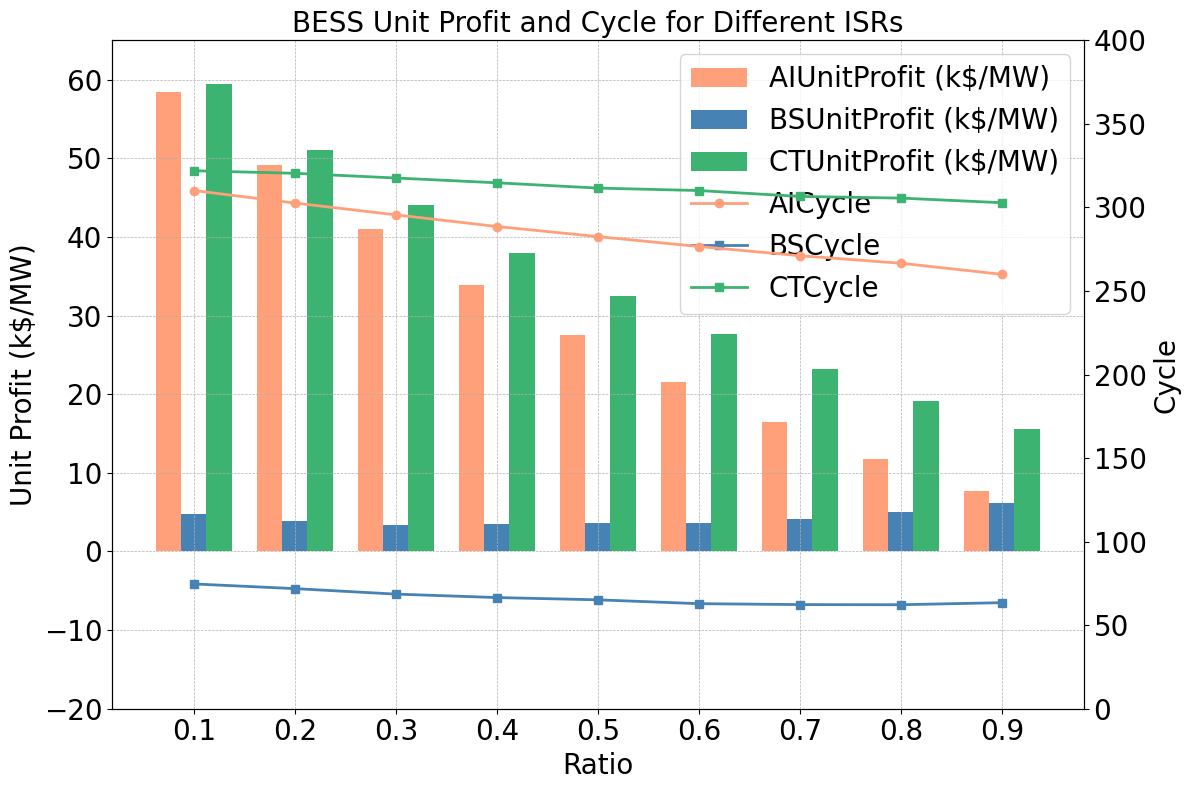

In [79]:
# Define a color palette
colors = ['#FFA07A', '#4682B4', '#3CB371', '#8B008B', '#FFD700']

# Plotting the results
fig, ax1 = plt.subplots(figsize=(12, 8))

# Set bar width
bar_width = 0.25
index = range(len(results_df))

# Plotting bars for AIUnitProfit and BSUnitProfit
bar1 = ax1.bar([i - bar_width for i in index], results_df['AIUnitProfit'], bar_width, label='AIUnitProfit (k$/MW)', color=colors[0])
bar2 = ax1.bar([i for i in index], results_df['BSUnitProfit'], bar_width, label='BSUnitProfit (k$/MW)', color=colors[1])
bar3 = ax1.bar([i + bar_width for i in index], results_df['CTUnitProfit'], bar_width, label='CTUnitProfit (k$/MW)', color=colors[2])


# Adding labels and title for the primary y-axis
ax1.set_xlabel('Ratio', fontsize=20)
ax1.set_ylabel('Unit Profit (k$/MW)', fontsize=20)
ax1.set_xticks(index)
ax1.set_xticklabels(results_df['Ratio'], fontsize=20)
ax1.tick_params(axis='y', labelsize=20)
ax1.tick_params(axis='x', labelsize=20)
ax1.set_ylim([-20, 65])


# Adding a secondary y-axis for AICycle and BSCycle
ax2 = ax1.twinx()
ax2.plot(index, results_df['AICycle'], label='AICycle', color=colors[0], linestyle='-', marker='o', linewidth=2)
ax2.plot(index, results_df['BSCycle'], label='BSCycle', color=colors[1], linestyle='-', marker='s', linewidth=2)
ax2.plot(index, results_df['CTCycle'], label='CTCycle', color=colors[2], linestyle='-', marker='s', linewidth=2)
ax2.set_ylabel('Cycle', fontsize=20)
ax2.set_ylim(0, 400)
ax2.tick_params(axis='y', labelsize=20)

# Adding grid lines for better readability
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

# Combining legends
bars_labels = [bar1, bar2, bar3]
lines_labels = [plt.Line2D([0], [0], color=colors[0], linestyle='-', marker='o', linewidth=2, label='AICycle'),
                plt.Line2D([0], [0], color=colors[1], linestyle='-', marker='s', linewidth=2, label='BSCycle'),
                plt.Line2D([0], [0], color=colors[2], linestyle='-', marker='s', linewidth=2, label='CTCycle')]

combined_legend = bars_labels + lines_labels
ax1.legend(handles=combined_legend, loc='upper right', fontsize=20)

# Adding title
plt.title('BESS Unit Profit and Cycle for Different ISRs', fontsize=20)

# Improving layout
plt.tight_layout()

# Display the plot
plt.show()

In [48]:
case_template = 'Strategic/Cases/5GW/ED1_Strategic_true_FORB_true_ratio{}_Seg5_BAW0_BSESCbid0.5'

ratios = [round(i * 0.1+0.1, 1) for i in range(10)]
region = 2

# Initialize an empty list to store results
results = []

# Loop over ratios from 0.0 to 1.0 (assuming increment by 0.1)
for ratio in ratios:
    if (ratio <= 0.9) & (ratio >=0.1):
        case = case_template.format(ratio)
        try:
            # Try to read the CSV file for the current case
            ESD = pd.read_csv('output/'+case+'/EDESD.csv',header=None)
            ESC = pd.read_csv('output/'+case+'/EDESC.csv',header=None)
            price = pd.read_csv('output/'+case+'/EDprice.csv',header=None)
            ESindex = pd.read_csv('output/'+case+'/Strategic/storage_to_index_map.csv')
            ES = pd.read_csv('output/'+case+'/Strategic/ADDED_ES.csv')
        except FileNotFoundError:
            print(f"File for case {case} not found.")
            continue

        ESID = ESindex[ESindex['Region']==region]['StorageID']
        i = region -1
        AIRevenue = sum((ESD[ESID-1]-ESC[ESID-1]).iloc[:, 0]*price[i])/1000
        BSRevenue = sum((ESD[ESID]-ESC[ESID]).iloc[:, 0]*price[i])/1000
        AIProfit = AIRevenue - sum(Ts*c*ESD[ESID-1].iloc[:, 0])/1000
        BSProfit = BSRevenue - sum(Ts*c*ESD[ESID].iloc[:, 0])/1000
        AIUnitProfit = AIProfit/ES['EPD'][2*i]
        BSUnitProfit = BSProfit/ES['EPD'][2*i+1]
        AICycle = sum(ESD[ESID-1].iloc[:, 0])/eta*Ts/ES['ESOC'][2*i]
        BSCycle = sum(ESD[ESID].iloc[:, 0])/eta*Ts/ES['ESOC'][2*i+1]
        
        # Append results to list
        results.append({
            'Ratio': ratio,
            'AIRevenue': AIRevenue,
            'BSRevenue': BSRevenue,
            'AIProfit': AIProfit,
            'BSProfit': BSProfit,
            'AIUnitProfit': AIUnitProfit,
            'BSUnitProfit': BSUnitProfit,
            'AICycle': AICycle,
            'BSCycle': BSCycle
        })

# Convert list of dictionaries to DataFrame
results_df = pd.DataFrame(results)
results_df
#     AIRevenue = sum((ESD[35]-ESC[35])*price[0])/1000

#     # Calculate stats and transpose
#     pricestats = pd.concat([price.mean()*12, (price*12).std()], axis=1).T

#     # Now, instead of appending Series objects, you create DataFrame slices for each and append them
#     mean_prices_dfs.append(pricestats.iloc[[0]])
#     std_prices_dfs.append(pricestats.iloc[[1]])

# case = 'Strategic/Exp/2022/UC25ED1_Strategic_true_FORB_true_ratio0.1_Seg1_BAW0_Fuel2.0_NLC2.0_Error0.25_ESPeakBidAdjustment1.0_ESPeakBid100.0NegativeRenew_1.0-2.0-2.0-2.0-2.0'

# ESD = pd.read_csv('output/'+case+'/EDESD.csv',header=None)
# ESC = pd.read_csv('output/'+case+'/EDESC.csv',header=None)
# price = pd.read_csv('output/'+case+'/EDprice.csv',header=None)
# ESindex = pd.read_csv('output/'+case+'/Strategic/storage_to_index_map.csv')
# ES = pd.read_csv('output/'+case+'/Strategic/ADDED_ES.csv')


,Ratio,AIRevenue,BSRevenue,AIProfit,BSProfit,AIUnitProfit,BSUnitProfit,AICycle,BSCycle
0,0.1,29571.589308,33549.438916,21397.870872,15842.703126,58.376006,4.802314,309.706978,74.546510
1,0.2,52127.349266,26700.420870,36171.162718,11509.743558,49.339675,3.924998,302.294626,71.947957
2,0.3,68696.168639,21538.823393,45318.431449,8763.537485,41.211406,3.415429,295.265384,69.151866
3,0.4,80330.594534,17993.254249,49740.377936,7465.459331,33.924457,3.394448,289.770305,66.484052
4,0.5,87545.477396,15080.749677,50124.008839,6469.807501,27.348884,3.530085,283.584272,65.254728
5,0.6,91638.013122,12008.413185,47745.193659,5311.838333,21.709120,3.622836,277.187439,63.434286
6,0.7,92501.904248,9464.942305,42363.386825,4503.371436,16.510356,4.095249,271.396827,62.665609
7,0.8,90791.750471,6944.194004,34578.340461,3630.934586,11.791742,4.952817,266.244878,62.770670
8,0.9,86374.552193,3896.182936,24625.173390,2221.250042,7.464498,6.059841,259.968903,63.464188


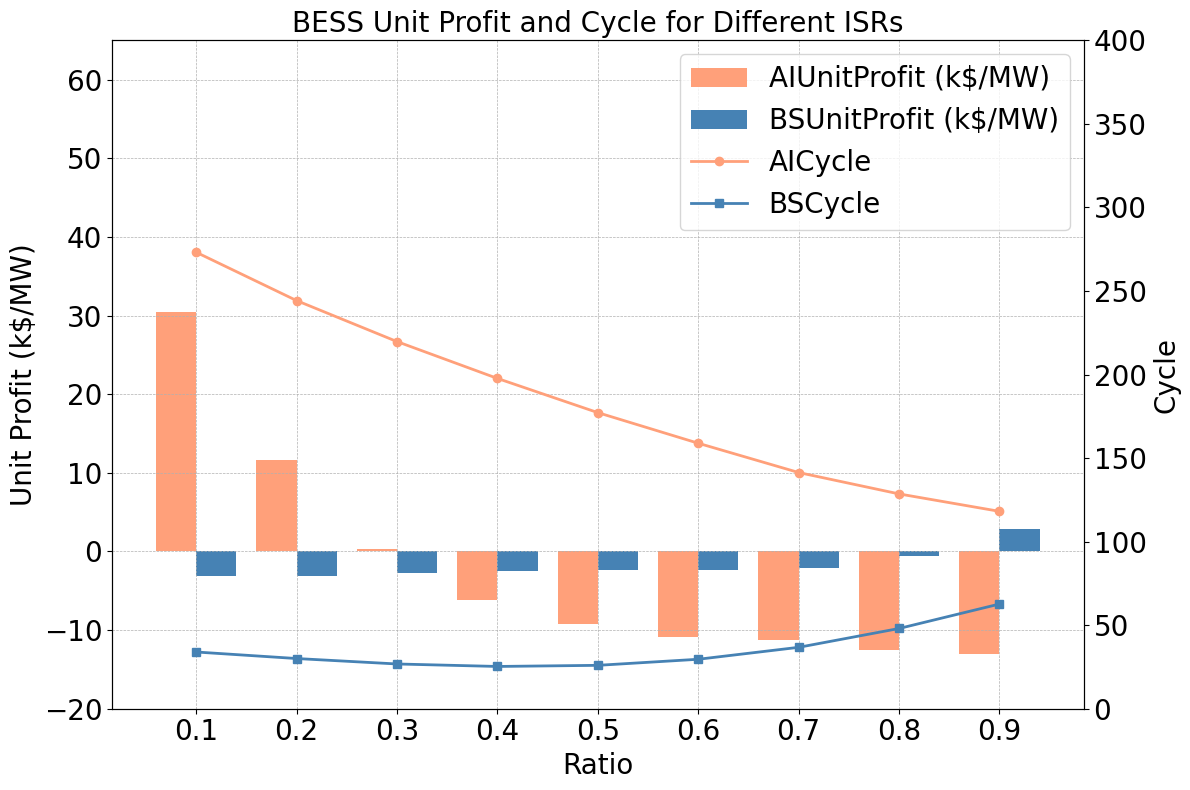

In [6]:
# Define a color palette
colors = ['#FFA07A', '#4682B4', '#FFA07A', '#4682B4']

# Plotting the results
fig, ax1 = plt.subplots(figsize=(12, 8))

# Set bar width
bar_width = 0.4
index = range(len(results_df))

# Plotting bars for AIUnitProfit and BSUnitProfit
bar1 = ax1.bar([i - bar_width/2 for i in index], results_df['AIUnitProfit'], bar_width, label='AIUnitProfit (k$/MW)', color=colors[0])
bar2 = ax1.bar([i + bar_width/2 for i in index], results_df['BSUnitProfit'], bar_width, label='BSUnitProfit (k$/MW)', color=colors[1])

# Adding labels and title for the primary y-axis
ax1.set_xlabel('Ratio', fontsize=20)
ax1.set_ylabel('Unit Profit (k$/MW)', fontsize=20)
ax1.set_xticks(index)
ax1.set_xticklabels(results_df['Ratio'], fontsize=20)
ax1.tick_params(axis='y', labelsize=20)
ax1.tick_params(axis='x', labelsize=20)
ax1.set_ylim([-20, 65])


# Adding a secondary y-axis for AICycle and BSCycle
ax2 = ax1.twinx()
ax2.plot(index, results_df['AICycle'], label='AICycle', color=colors[2], linestyle='-', marker='o', linewidth=2)
ax2.plot(index, results_df['BSCycle'], label='BSCycle', color=colors[3], linestyle='-', marker='s', linewidth=2)
ax2.set_ylabel('Cycle', fontsize=20)
ax2.set_ylim(0, 400)
ax2.tick_params(axis='y', labelsize=20)

# Adding grid lines for better readability
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

# Combining legends
bars_labels = [bar1, bar2]
lines_labels = [plt.Line2D([0], [0], color=colors[2], linestyle='-', marker='o', linewidth=2, label='AICycle'),
                plt.Line2D([0], [0], color=colors[3], linestyle='-', marker='s', linewidth=2, label='BSCycle')]

combined_legend = bars_labels + lines_labels
ax1.legend(handles=combined_legend, loc='upper right', fontsize=20)

# Adding title
plt.title('BESS Unit Profit and Cycle for Different ISRs', fontsize=20)

# Improving layout
plt.tight_layout()

# Display the plot
plt.show()

In [ ]:
# Define a color palette
colors = ['#2E8B57', '#6A5ACD', '#FFA07A', '#4682B4']

# Plotting the results
fig, ax = plt.subplots(figsize=(14, 8))

# Set bar width
bar_width = 0.2
index = range(len(results_df))

# Plotting each bar with improved visuals
bar1 = ax.bar([i - bar_width*1.5 for i in index], results_df['AIRevenue'], bar_width, label='AIRevenue', color=colors[0])
bar2 = ax.bar([i - bar_width*0.5 for i in index], results_df['AIProfit'], bar_width, label='AIProfit', color=colors[1])
bar3 = ax.bar([i + bar_width*0.5 for i in index], results_df['BSRevenue'], bar_width, label='BSRevenue', color=colors[2])
bar4 = ax.bar([i + bar_width*1.5 for i in index], results_df['BSProfit'], bar_width, label='BSProfit', color=colors[3])

# Adding labels and title
ax.set_xlabel('Ratio', fontsize=20)
ax.set_ylabel('Value (in k$)', fontsize=20)
ax.set_title('Revenue and Profit for Different ISR', fontsize=20)
ax.set_xticks(index)
ax.set_xticklabels(results_df['Ratio'], fontsize=20)
ax.legend(fontsize=20)
ax.tick_params(axis='y', labelsize=20)
# Adding grid lines for better readability
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Improving layout
plt.tight_layout()

# Display the plot
plt.show()


In [ ]:
ESID

In [ ]:
ESD[ESID-1].max()*4

In [ ]:
ESC[ESID-1].max()*4

In [ ]:
ES['ESOC'][2*i]

In [ ]:
i = 1
region = i+1
ESID = ESindex[ESindex['Region']==region]['StorageID']
AIRevenue = sum((ESD[ESID-1]-ESC[ESID-1]).iloc[:, 0]*price[i])/1000
BSRevenue = sum((ESD[ESID]-ESC[ESID]).iloc[:, 0]*price[i])/1000
AIProfit = AIRevenue - sum(Ts*c*ESD[ESID-1].iloc[:, 0])/1000
BSProfit = BSRevenue - sum(Ts*c*ESD[ESID].iloc[:, 0])/1000
AIUnitProfit = AIProfit/ES['ESOC'][2*i]
BSUnitProfit = BSProfit/ES['ESOC'][2*i+1]
AICycle = sum(ESD[ESID-1].iloc[:, 0])/eta*Ts/ES['ESOC'][2*i]
BSCycle = sum(ESD[ESID].iloc[:, 0])/eta*Ts/ES['ESOC'][2*i+1]
print(AIRevenue,BSRevenue, AIProfit, BSProfit, AIUnitProfit, BSUnitProfit, AICycle, BSCycle)

In [ ]:
data = [
    ['S1', sum((ESD[35]-ESC[35])*price[0])/1000, sum((ESD[35]-ESC[35])*price[0] - Ts*c*ESD[35])/1000, sum((ESD[35]-ESC[35])*price[0] - Ts*c*ESD[35])/1000/ES['ESOC'][0], sum(ESD[35])/eta*Ts/ES['ESOC'][0]],
    ['NS1', sum((ESD[36]-ESC[36])*price[0])/1000, sum((ESD[36]-ESC[36])*price[0] - Ts*c*ESD[36])/1000, sum((ESD[36]-ESC[36])*price[0] - Ts*c*ESD[36])/1000/ES['ESOC'][1], sum(ESD[36])/eta*Ts/ES['ESOC'][1]],
    ['S2', sum((ESD[37]-ESC[37])*price[1])/1000, sum((ESD[37]-ESC[37])*price[1] - Ts*c*ESD[37])/1000, sum((ESD[37]-ESC[37])*price[1] - Ts*c*ESD[37])/1000/ES['ESOC'][2], sum(ESD[37])/eta*Ts/ES['ESOC'][2]],
    ['NS2', sum((ESD[38]-ESC[38])*price[1])/1000, sum((ESD[38]-ESC[38])*price[1] - Ts*c*ESD[38])/1000, sum((ESD[38]-ESC[38])*price[1] - Ts*c*ESD[38])/1000/ES['ESOC'][3], sum(ESD[38])/eta*Ts/ES['ESOC'][3]],
    ['S3', sum((ESD[39]-ESC[39])*price[2])/1000, sum((ESD[39]-ESC[39])*price[2] - Ts*c*ESD[39])/1000, sum((ESD[39]-ESC[39])*price[2] - Ts*c*ESD[39])/1000/ES['ESOC'][4], sum(ESD[39])/eta*Ts/ES['ESOC'][4]],
    ['NS3', sum((ESD[40]-ESC[40])*price[2])/1000, sum((ESD[40]-ESC[40])*price[2] - Ts*c*ESD[40])/1000, sum((ESD[40]-ESC[40])*price[2] - Ts*c*ESD[40])/1000/ES['ESOC'][5], sum(ESD[40])/eta*Ts/ES['ESOC'][5]],
    ['S4', sum((ESD[41]-ESC[41])*price[3])/1000, sum((ESD[41]-ESC[41])*price[3] - Ts*c*ESD[41])/1000, sum((ESD[41]-ESC[41])*price[3] - Ts*c*ESD[41])/1000/ES['ESOC'][6], sum(ESD[41])/eta*Ts/ES['ESOC'][6]],
    ['NS4', sum((ESD[42]-ESC[42])*price[3])/1000, sum((ESD[42]-ESC[42])*price[3] - Ts*c*ESD[42])/1000, sum((ESD[42]-ESC[42])*price[3] - Ts*c*ESD[42])/1000/ES['ESOC'][7], sum(ESD[42])/eta*Ts/ES['ESOC'][7]],
    ['S5', sum((ESD[43]-ESC[43])*price[4])/1000, sum((ESD[43]-ESC[43])*price[4] - Ts*c*ESD[43])/1000, sum((ESD[43]-ESC[43])*price[4] - Ts*c*ESD[43])/1000/ES['ESOC'][8], sum(ESD[43])/eta*Ts/ES['ESOC'][8]],
    ['NS5', sum((ESD[44]-ESC[44])*price[4])/1000, sum((ESD[44]-ESC[44])*price[4] - Ts*c*ESD[44])/1000, sum((ESD[44]-ESC[44])*price[4] - Ts*c*ESD[44])/1000/ES['ESOC'][9], sum(ESD[44])/eta*Ts/ES['ESOC'][9]],
    ['S6', sum((ESD[45]-ESC[45])*price[5])/1000, sum((ESD[45]-ESC[45])*price[5] - Ts*c*ESD[45])/1000, sum((ESD[45]-ESC[45])*price[5] - Ts*c*ESD[45])/1000/ES['ESOC'][10], sum(ESD[45])/eta*Ts/ES['ESOC'][10]],
    ['NS6', sum((ESD[46]-ESC[46])*price[5])/1000, sum((ESD[46]-ESC[46])*price[5] - Ts*c*ESD[46])/1000, sum((ESD[45]-ESC[45])*price[5] - Ts*c*ESD[46])/1000/ES['ESOC'][11], sum(ESD[46])/eta*Ts/ES['ESOC'][11]],
]
column_names = ['', 'Revenue (k$)', 'Profit (k$)', 'Unit Profit (k$/MWh)', 'Cycle']
df = pd.DataFrame(data, columns=column_names)
df.T


### Storage Profit & Utilization (Heterogeneous ISR 0.0/1.0)

In [ ]:
# case = 'Strategic/Exp1.2/2022/ED1_Strategic_true_FORB_true_ratio0.0_Seg1_BAW0_1.0-2.0-2.0-2.0-2.0'
case = 'Strategic/Quad/2022/ED1_Strategic_true_FORB_true_ratio0.0_Seg1_BAW0_BSESCbid0.5'

ESD = pd.read_csv('output/'+case+'/EDESD.csv',header=None)
ESC = pd.read_csv('output/'+case+'/EDESC.csv',header=None)
price = pd.read_csv('output/'+case+'/EDprice.csv',header=None)
ESindex = pd.read_csv('output/'+case+'/Strategic/storage_to_index_map.csv')
ES = pd.read_csv('2032 ADS PCM V2.4.1 Public Data/Processed Data/2022/Storage_C_4hr_5GW_Strategic_Agg.csv')

In [ ]:
ESD[ESID-1].max()

In [ ]:
ESD[ESID-1].max()

In [ ]:
i = 1
region = i+1
ESID = region+35
AIRevenue = sum((ESD[ESID-1]-ESC[ESID-1])*price[i])/1000
# BSRevenue = sum((ESD[ESID]-ESC[ESID]).iloc[:, 0]*price[i])/1000
AIProfit = AIRevenue - sum(Ts*c*ESD[ESID-1])/1000
# BSProfit = BSRevenue - sum(Ts*c*ESD[ESID].iloc[:, 0])/1000
AIUnitProfit = AIProfit/ES['MaxCap(MWh)'][ESID-1]
# BSUnitProfit = BSProfit/ES['ESOC'][2*i+1]
AICycle = sum(ESD[ESID-1])/eta*Ts/ES['MaxCap(MWh)'][ESID-1]
# BSCycle = sum(ESD[ESID].iloc[:, 0])/eta*Ts/ES['ESOC'][2*i+1]
# print(AIRevenue,BSRevenue, AIProfit, BSProfit, AIUnitProfit, BSUnitProfit, AICycle, BSCycle)
print(AIRevenue, AIProfit, AIUnitProfit, AICycle)

In [ ]:
for ratio in ratios:
    case = case_template.format(ratio)
    try:
        # Try to read the CSV file for the current case
        ESInfo = pd.read_csv('output/'+case+'/Strategic/storage_to_index_map.csv')
    except FileNotFoundError:
        print(f"File for case {case} not found.")
        continue

In [ ]:
ESD1 = pd.read_csv('output/Strategic/2022/UC25ED1_Strategic_true_ratio1.0_Seg1_BAW0_MC20.0_1/EDESD.csv',header=None)
ESC1 = pd.read_csv('output/Strategic/2022/UC25ED1_Strategic_true_ratio1.0_Seg1_BAW0_MC20.0_1/EDESC.csv',header=None)
price1 = pd.read_csv('output/Strategic/2022/UC25ED1_Strategic_true_ratio1.0_Seg1_BAW0_MC20.0_1/EDprice.csv',header=None)
DAprice1 = pd.read_csv('output/Strategic/2022/UC25ED1_Strategic_true_ratio1.0_Seg1_BAW0_MC20.0_1/UCprice.csv',header=None)

In [ ]:
repeated_indices = np.repeat(DAprice1.index, 12)
repeated_DAprice1 = DAprice1.loc[repeated_indices].reset_index(drop=True)

In [ ]:
plt.figure(figsize=(10, 6))  # Optional: Specifies the figure size
plt.plot(range(2017), price1.loc[0:2016,0]*12, label='RT')  # Plot first column
plt.plot(range(2017), repeated_DAprice1.loc[0:2016,0], label='DA', linestyle='--')  # Plot second column with a different style

# Adding labels and title
# plt.xlabel('Index')  # Adjust as per your requirement
plt.ylabel('$/MWh')  # Adjust as per your requirement
# plt.title('Line Plot of Two DataFrame Columns')
plt.legend()

# Show plot
plt.show()

In [ ]:
Zone2Price1 = price1[0]
SD1 = ESD1[35]
SC1 = ESC1[35]
NSD1 = ESD1[36]
NSC1 = ESC1[36]
Zone2Price5 = price5[0]
SD5 = ESD5[35]
SC5 = ESC5[35]
NSD5 = ESD5[36]
NSC5 = ESC5[36]
Zone2Price1mar = price1mar[0]
SD1mar = ESD1mar[35]
SC1mar = ESC1mar[35]
NSD1mar = ESD1mar[36]
NSC1mar = ESC1mar[36]
Zone2Price5mar = price5mar[1]
SD5mar = ESD5mar[35]
SC5mar = ESC5mar[35]
NSD5mar = ESD5mar[36]
NSC5mar = ESC5mar[36]

In [ ]:
S1 = SD1-SC1
NS1 = NSD1-NSC1
S5 = SD5-SC5
NS5 = NSD5-NSC5
S1mar = SD1mar-SC1mar
NS1mar = NSD1mar-NSC1mar
S5mar = SD5mar-SC5mar
NS5mar = NSD5mar-NSC5mar

In [ ]:
Revenue_S1 = sum(S1*Zone2Price1) 
Profit_S1 = sum(S1*Zone2Price1 - Ts*c*SD1)
Cycle_S1 = sum(SD1)/eta*Ts/E
Revenue_NS1 = sum(NS1*Zone2Price1)
Profit_NS1 = sum(NS1*Zone2Price1 - Ts*c*NSD1)
Cycle_NS1 = sum(NSD1)/eta*Ts/E


In [ ]:
Revenue_S5 = sum(S5*Zone2Price5) 
Profit_S5 = sum(S5*Zone2Price5 - Ts*c*SD5)
Cycle_S5 = sum(SD5)/eta*Ts/E
Revenue_NS5 = sum(NS5*Zone2Price5)
Profit_NS5 = sum(NS5*Zone2Price5 - Ts*c*NSD5) 
Cycle_NS5 = sum(NSD5)/eta*Ts/E


In [ ]:
Revenue_S1mar = sum(S1mar*Zone2Price1mar) 
Profit_S1mar = sum(S1mar*Zone2Price1mar - Ts*c*SD1mar)
Cycle_S1mar = sum(SD1mar)/eta*Ts/E1
Revenue_NS1mar = sum(NS1mar*Zone2Price1mar)
Profit_NS1mar = sum(NS1mar*Zone2Price1mar - Ts*c*NSD1mar) 
Cycle_NS1mar = sum(NSD1mar)/eta*Ts/E2

In [ ]:
Revenue_S5mar = sum(S5mar*Zone2Price5mar) 
Profit_S5mar = sum(S5mar*Zone2Price5mar - Ts*c*SD5mar)
Cycle_S5mar = sum(SD5mar)/eta*Ts/E1
Revenue_NS5mar = sum(NS5mar*Zone2Price5mar)
Profit_NS5mar = sum(NS5mar*Zone2Price5mar - Ts*c*NSD5mar) 
Cycle_NS5mar = sum(NSD5mar)/eta*Ts/E2

In [ ]:
data = [
    ['S-1Seg', Revenue_S1/1000, Profit_S1/1000, Profit_S1/1000/E, Cycle_S1, Profit_S1/1000/E/27.992],
    ['NS-1Seg', Revenue_NS1/1000, Profit_NS1/1000, Profit_NS1/1000/E, Cycle_NS1, Profit_NS1/1000/E/27.992],
    ['S-5Seg', Revenue_S5/1000, Profit_S5/1000, Profit_S5/1000/E, Cycle_S5, Profit_S5/1000/E/27.992],
    ['NS-5Seg', Revenue_NS5/1000, Profit_NS5/1000, Profit_NS5/1000/E, Cycle_NS5, Profit_NS5/1000/E/27.992],
    ['S-1Seg_mar', Revenue_S1mar/1000, Profit_S1mar/1000, Profit_S1mar/1000/E1, Cycle_S1mar, Profit_S1mar/1000/E1/27.992],
    ['NS-1Seg_mar', Revenue_NS1mar/1000, Profit_NS1mar/1000, Profit_NS1mar/1000/E2, Cycle_NS1mar, Profit_NS1mar/1000/E2/27.992],
    ['S-5Seg_mar', Revenue_S5mar/1000, Profit_S5mar/1000, Profit_S5mar/1000/E1, Cycle_S5mar, Profit_S5mar/1000/E1/27.992],
    ['NS-5Seg_mar', Revenue_NS5mar/1000, Profit_NS5mar/1000, Profit_NS5mar/1000/E2, Cycle_NS5mar, Profit_NS5mar/1000/E2/27.992],
]
column_names = ['', 'Revenue (k$)', 'Profit (k$)', 'Unit Profit (k$/MWh)', 'Cycle', 'Profit Ratio']
df = pd.DataFrame(data, columns=column_names)
df


In [ ]:
# Set the positions and width for the bars
positions = range(len(df))
width = 0.35

# Plotting the bar chart
fig, ax1 = plt.subplots()

# Bars for Revenue and Profit
revenue_bars = ax1.bar(positions, df['Revenue (k$)']/100, width, label='Revenue (k$)', color='blue')
profit_bars = ax1.bar([p + width for p in positions], df['Profit (k$)']/100, width, label='Profit (k$)', color='orange')

# Add the second y-axis for the Profit Ratio
ax2 = ax1.twinx()
profit_ratio_dots, = ax2.plot([p + width/2 for p in positions], df['Profit Ratio'], 'ro', label='Profit Ratio')

# Set the ticks and ticklabels for the x-axis
ax1.set_xticks([p + width/2 for p in positions])
ax1.set_xticklabels(['S-1Seg', 'NS-1Seg', 'S-5Seg', 'NS-5Seg','S-1Seg', 'NS-1Seg', 'S-5Seg', 'NS-5Seg'])

# Set the axis labels
# ax1.set_xlabel('Segment')
ax1.set_ylabel('Revenue/Profit (k$)')
ax2.set_ylabel('Profit Ratio')

# Set the title of the graph
plt.title('Revenue, Profit and Profit Ratio (per MWh)')

# Create a legend by first getting handles and labels for the first y-axis and then the second y-axis
handles, labels = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles + [profit_ratio_dots], labels + labels2, loc='upper right')

# Adjust layout to make room for the legend
plt.tight_layout()

# Show the plot
plt.show()

## Generator Type

In [ ]:
Zone = 3

In [ ]:
ThermalGen = pd.read_csv('2032 ADS PCM V2.4.1 Public Data/Processed Data/2022/ThermalGen_Full_C.csv')

In [ ]:
ThermalGen['SubType'].unique()

In [ ]:
ThermalGen['Fuel Name'].unique()

### Coal

In [ ]:
ThermalGen[(ThermalGen['Zone']==Zone)&((ThermalGen['SubType']=='ST-Coal'))]

In [ ]:
ThermalGen[(ThermalGen['Zone']==Zone)&((ThermalGen['SubType']=='ST-Coal'))]['Fuel Name'].unique()

In [ ]:
ThermalGen[(ThermalGen['Zone']==Zone)&((ThermalGen['SubType']=='ST-Coal'))]['IOMaxCap(MW)'].sum()/1000

### ST

In [ ]:
ThermalGen[(ThermalGen['Zone']==Zone)&((ThermalGen['SubType']=='ST-NatGas')|(ThermalGen['SubType']=='ST-Other')|(ThermalGen['SubType']=='ST-WasteHeat'))]

In [ ]:
ThermalGen[(ThermalGen['Zone']==Zone)&((ThermalGen['SubType']=='ST-NatGas')|(ThermalGen['SubType']=='ST-Other')|(ThermalGen['SubType']=='ST-WasteHeat'))]['IOMaxCap(MW)'].sum()/1000

### CC

In [ ]:
ThermalGen[(ThermalGen['Zone']==Zone)&((ThermalGen['SubType']=='CCWhole-NatGas-SingleShaft')|(ThermalGen['SubType']=='CCWhole-NatGas-Aero')|(ThermalGen['SubType']=='CCWhole-NatGas-Industrial')|(ThermalGen['SubType']=='CCPart-Steam'))]

In [ ]:
ThermalGen[(ThermalGen['Zone']==Zone)&((ThermalGen['SubType']=='CCWhole-NatGas-SingleShaft')|(ThermalGen['SubType']=='CCWhole-NatGas-Aero')|(ThermalGen['SubType']=='CCWhole-NatGas-Industrial')|(ThermalGen['SubType']=='CCPart-Steam'))]['IOMaxCap(MW)'].sum()/1000

### CT

In [ ]:
ThermalGen[(ThermalGen['Zone']==Zone)&((ThermalGen['SubType']=='CT-NatGas-Aero')|(ThermalGen['SubType']=='CT-NatGas-Industrial')|(ThermalGen['SubType']=='CT-OilDistillate')|(ThermalGen['SubType']=='CT-Aero')|(ThermalGen['SubType']=='CT-AB-Cogen'))]

In [ ]:
ThermalGen[(ThermalGen['Zone']==Zone)&((ThermalGen['SubType']=='CT-NatGas-Aero')|(ThermalGen['SubType']=='CT-NatGas-Industrial')|(ThermalGen['SubType']=='CT-OilDistillate')|(ThermalGen['SubType']=='CT-Aero')|(ThermalGen['SubType']=='CT-AB-Cogen'))]['IOMaxCap(MW)'].sum()/1000

### Nuclear

In [ ]:
ThermalGen[(ThermalGen['Zone']==Zone)&((ThermalGen['SubType']=='ST-Nuclear'))]

In [ ]:
ThermalGen[(ThermalGen['Zone']==Zone)&((ThermalGen['SubType']=='ST-Nuclear'))]['IOMaxCap(MW)'].sum()/1000

### Geothermal

In [ ]:
ThermalGen[(ThermalGen['Zone']==Zone)&((ThermalGen['SubType']=='Geo-BinaryCycle')|(ThermalGen['SubType']=='Geo-DoubleFlash'))]

In [ ]:
ThermalGen[(ThermalGen['Zone']==Zone)&((ThermalGen['SubType']=='Geo-BinaryCycle')|(ThermalGen['SubType']=='Geo-DoubleFlash'))]['IOMaxCap(MW)'].sum()/1000

## BIO & ICE

In [ ]:
Zone = 6

In [ ]:
ThermalGen[(ThermalGen['Zone']==Zone)&((ThermalGen['SubType']=='Bio-ICE')|(ThermalGen['SubType']=='Bio-CT')|(ThermalGen['SubType']=='Bio-ST')|(ThermalGen['SubType']=='Bio-CC'))]

In [ ]:
ThermalGen[(ThermalGen['Zone']==Zone)&((ThermalGen['SubType']=='Bio-ICE')|(ThermalGen['SubType']=='Bio-CT')|(ThermalGen['SubType']=='Bio-ST')|(ThermalGen['SubType']=='Bio-CC'))]['Fuel Name'].unique()

In [ ]:
ThermalGen[(ThermalGen['Zone']==Zone)&((ThermalGen['SubType']=='Bio-ICE')|(ThermalGen['SubType']=='Bio-CT')|(ThermalGen['SubType']=='Bio-ST')|(ThermalGen['SubType']=='Bio-CC'))]['IOMaxCap(MW)'].sum()/1000

In [ ]:
ThermalGen[(ThermalGen['Zone']==Zone)&((ThermalGen['SubType']=='ICE-NatGas')|(ThermalGen['SubType']=='ICE-OilDistillate'))]

In [ ]:
ThermalGen[(ThermalGen['Zone']==Zone)&((ThermalGen['SubType']=='ICE-NatGas')|(ThermalGen['SubType']=='ICE-OilDistillate'))]['Fuel Name'].unique()

In [ ]:
ThermalGen[(ThermalGen['Zone']==Zone)&((ThermalGen['SubType']=='ICE-NatGas')|(ThermalGen['SubType']=='ICE-OilDistillate'))]['IOMaxCap(MW)'].sum()/1000

### Renewables

In [ ]:
HydroGen = pd.read_csv('2032 ADS PCM V2.4.1 Public Data/Processed Data/2022/HydroZoneCap_C.csv')

In [ ]:
HydroGen['MaxCap(MW)']/1000

In [ ]:
SolarGen = pd.read_csv('2032 ADS PCM V2.4.1 Public Data/Processed Data/2022/Solar_C.csv')

In [ ]:
SolarGen['SubType'].unique()

In [ ]:
SolarGen[(SolarGen['Zone']==Zone)&(SolarGen['SubType']=='SolarThermal-CSP6')]['Capacity(MW)'].sum()/1000

In [ ]:
SolarGen[(SolarGen['Zone']==Zone)&(SolarGen['SubType']!='SolarThermal-CSP6')]['Capacity(MW)'].sum()/1000

In [ ]:
WindGen = pd.read_csv('2032 ADS PCM V2.4.1 Public Data/Processed Data/2022/Wind_C.csv')

In [ ]:
WindGen[WindGen['Zone']==Zone]['Capacity(MW)'].sum()/1000

### Storage

In [ ]:
Storage = pd.read_csv('2032 ADS PCM V2.4.1 Public Data/Processed Data/2022/Storage_C_4hr_5GW_Strategic.csv')

In [ ]:
Storage['SubType'].unique()

In [ ]:
Storage[(Storage['Zone']==Zone)&((Storage['SubType']=='PS-Hydro')|(Storage['SubType']=='PS-HydroRPS'))]

In [ ]:
Storage[(Storage['Zone']==Zone)&((Storage['SubType']=='PS-Hydro')|(Storage['SubType']=='PS-HydroRPS'))]['MaxCap(MW)'].sum()/1000

In [ ]:
Storage[(Storage['Zone']==Zone)&((Storage['SubType']=='Battery Storage'))]

In [ ]:
Storage[(Storage['Zone']==Zone)&((Storage['SubType']=='Battery Storage'))]['MaxCap(MW)'].sum()/1000

## Plot

In [ ]:
HistoryPrice = pd.read_csv('output/20220101-20221231 CAISO Real-time Price.csv')
HistoryPrice = HistoryPrice.drop_duplicates(subset=['Date', 'hub'])
Pivot_HistoryPrice = HistoryPrice.pivot(index='Date', columns='hub', values='price')

case1 = 'Strategic/UC25ED1_Strategic_true_Seg1_Load1.0_Fuel1.2_Error0.25_ratio0.1_MIP0.1_DARTDP'
RTPrice1 = pd.read_csv('output/'+case1+'/EDprice.csv',header=None)*12
case5 = 'Strategic/UC25ED1_Strategic_true_Seg5_Load1.0_Fuel1.2_Error0.25_ratio0.1_MIP0.1_DARTDP'
RTPrice5 = pd.read_csv('output/'+case5+'/EDprice.csv',header=None)*12
case1mar = 'Strategic/UC25ED1_Strategic_true_Seg1_Load1.0_Fuel1.2_Error0.25_Margin_MIP0.1_NSDAB'
RTPrice1mar = pd.read_csv('output/'+case1+'/EDprice.csv',header=None)*12
case5mar = 'Strategic/UC25ED1_Strategic_true_Seg5_Load1.0_Fuel1.2_Error0.25_Margin_MIP0.1_NSDAB'
RTPrice5mar = pd.read_csv('output/'+case5+'/EDprice.csv',header=None)*12
case3 = 'DecUpdate/UC25ED1_Strategic_false_Seg1_Load1.0_Fuel1.2_Error0.25_5GWBES_1yr_ESBid_Emergen'
RTPrice3 = pd.read_csv('output/'+case3+'/EDprice.csv',header=None)*12

# Create a 2x4 grid of subplots
# fig, axs = plt.subplots(2, 4, figsize=(16, 9))
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

# Loop through each column and each subplot
for idx, (col, ax) in enumerate(zip([0,1], axs.flatten())):
    sorted_vals = np.sort(Pivot_HistoryPrice.iloc[:,col].values)[::-1]
    sorted_vals1 = np.sort(RTPrice1[col].values)[::-1]
    sorted_vals2 = np.sort(RTPrice5[col].values)[::-1]
    sorted_vals1mar = np.sort(RTPrice1mar[col].values)[::-1]
    sorted_vals2mar = np.sort(RTPrice5mar[col].values)[::-1]
    sorted_vals3 = np.sort(RTPrice3[col].values)[::-1]
    
    # Calculate the "reverse" cumulative distribution
    cdf = np.arange(1, len(sorted_vals) + 1) / float(len(sorted_vals))
    cdf1 = np.arange(1, len(sorted_vals1) + 1) / float(len(sorted_vals1))
    cdf2 = np.arange(1, len(sorted_vals2) + 1) / float(len(sorted_vals2))
    cdf1mar = np.arange(1, len(sorted_vals1mar) + 1) / float(len(sorted_vals1mar))
    cdf2mar = np.arange(1, len(sorted_vals2mar) + 1) / float(len(sorted_vals2mar))
    cdf3 = np.arange(1, len(sorted_vals3) + 1) / float(len(sorted_vals3))

    
    # Plot the CDF
    ax.plot(cdf,sorted_vals)
    ax.plot(cdf1,sorted_vals1)
    ax.plot(cdf2,sorted_vals2)
#     ax.plot(cdf1mar,sorted_vals1mar, linestyle='--')
#     ax.plot(cdf2mar,sorted_vals2mar, linestyle='--')
    ax.plot(cdf3,sorted_vals3)

    ax.set_xlim(0.00, 1)
    ax.set_ylim(-50, 500)
    ax.legend(['Historical','Seg1', 'Seg5', 'Base'],fontsize=20)
    ax.set_title(f"High Price CDF of Region {idx+1}",fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.set_ylabel("Real-time Price ($/MWh)",fontsize=20)

plt.tight_layout()
plt.show()

### FOR Tuning

In [ ]:
HistoryPrice = pd.read_csv('output/20220101-20221231 CAISO Real-time Price.csv')
HistoryPrice = HistoryPrice.drop_duplicates(subset=['Date', 'hub'])
Pivot_HistoryPrice = HistoryPrice.pivot(index='Date', columns='hub', values='price')

case1 = 'Strategic/6Regions3+5/2022/UC25ED1_Strategic_true_ratio1.0_Seg1_BAW0_Fuel1.0_NLC1.0_Error0.25NegativeRenew_1.0-1.0-1.0-1.0-1.0'
RTPrice1 = pd.read_csv('output/'+case1+'/EDprice.csv',header=None)*12
case2 = 'Strategic/FOR/2022/UC25ED1_Strategic_true_FORB_true_ratio1.0_Seg1_BAW0_Fuel1.0_NLC1.0_Error0.25_ESPeakBidAdjustment1.0_ESPeakBid100.0NegativeRenew_1.0-1.0-1.0-1.0-1.0'
RTPrice2 = pd.read_csv('output/'+case2+'/EDprice.csv',header=None)*12
case3 = 'remote/FOR/2022/UC25ED1_Strategic_true_FORB_true_ratio1.0_Seg1_BAW0_Fuel1.0_NLC1.0_Error0.25_ESPeakBidAdjustment1.0_ESPeakBid100.0NegativeRenew_1.0-1.0-1.0-1.0-1.0test'
RTPrice3 = pd.read_csv('output/'+case3+'/EDprice.csv',header=None)*12
case4 = 'remote/FOR/2022/UC25ED1_Strategic_true_FORB_true_ratio1.0_Seg1_BAW0_Fuel2.0_NLC2.0_Error0.25_ESPeakBidAdjustment1.0_ESPeakBid100.0NegativeRenew_1.0-2.0-2.0-2.0-2.0test'
RTPrice4 = pd.read_csv('output/'+case4+'/EDprice.csv',header=None)*12
case5 = 'remote/FOR/2022/UC25ED1_Strategic_true_FORB_true_ratio1.0_Seg1_BAW0_Fuel2.0_NLC2.0_Error0.25_ESPeakBidAdjustment1.0_ESPeakBid100.0NegativeRenew_1.0-2.0-3.0-3.0-3.0test'
RTPrice5 = pd.read_csv('output/'+case5+'/EDprice.csv',header=None)*12

# Create a 2x4 grid of subplots
# fig, axs = plt.subplots(2, 4, figsize=(16, 9))
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

# Loop through each column and each subplot
for idx, (col, ax) in enumerate(zip([0,1], axs.flatten())):
    sorted_vals = np.sort(Pivot_HistoryPrice.iloc[:,col].values)[::-1]
    sorted_vals1 = np.sort(RTPrice1[col].values)[::-1]
    sorted_vals2 = np.sort(RTPrice2[col].values)[::-1]
    sorted_vals3 = np.sort(RTPrice3[col].values)[::-1]
    sorted_vals4 = np.sort(RTPrice4[col].values)[::-1]
    sorted_vals5 = np.sort(RTPrice5[col].values)[::-1]

    
    # Calculate the "reverse" cumulative distribution
    cdf = np.arange(1, len(sorted_vals) + 1) / float(len(sorted_vals))
    cdf1 = np.arange(1, len(sorted_vals1) + 1) / float(len(sorted_vals1))
    cdf2 = np.arange(1, len(sorted_vals2) + 1) / float(len(sorted_vals2))
    cdf3 = np.arange(1, len(sorted_vals3) + 1) / float(len(sorted_vals3))
    cdf4 = np.arange(1, len(sorted_vals4) + 1) / float(len(sorted_vals4))
    cdf5 = np.arange(1, len(sorted_vals5) + 1) / float(len(sorted_vals5))
    
    # Plot the CDF
    ax.plot(cdf,sorted_vals)
    ax.plot(cdf1,sorted_vals1)
    ax.plot(cdf2,sorted_vals2)
    ax.plot(cdf3,sorted_vals3)
    ax.plot(cdf4,sorted_vals4)
    ax.plot(cdf5,sorted_vals5)

    ax.set_xlim(0.0, 1.0)
    ax.set_ylim(-60, 300)
    ax.legend(['Historical', 'Base', 'Forced Outage', 'Forced Outage_R', 'N2F2-12222', 'N2F2-12333'],fontsize=20)
    ax.set_title(f"Price Duration Curve of Region {idx+1}",fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.set_ylabel("Real-time Price ($/MWh)",fontsize=20)

plt.tight_layout()
plt.show()

In [ ]:
HistoryPrice = pd.read_csv('output/20220101-20221231 CAISO Real-time Price.csv')
HistoryPrice = HistoryPrice.drop_duplicates(subset=['Date', 'hub'])
Pivot_HistoryPrice = HistoryPrice.pivot(index='Date', columns='hub', values='price')

case1 = 'remote/FOR/2022/UC25ED1_Strategic_true_FORB_true_ratio1.0_Seg1_BAW0_Fuel2.0_NLC2.0_Error0.25_ESPeakBidAdjustment1.0_ESPeakBid100.0NegativeRenew_1.0-2.0-2.0-2.0-2.0test'
RTPrice1 = pd.read_csv('output/'+case1+'/EDprice.csv',header=None)*12
case2 = 'remote/FOR/2022/UC25ED1_Strategic_true_FORB_true_heto_false_ratio1.0_Seg1_BAW0_Fuel2.0_NLC2.0_Error0.25_ESPeakBidAdjustment1.0_ESPeakBid100.0NegativeRenew_1.0-2.0-2.0-2.0-2.0'
RTPrice2 = pd.read_csv('output/'+case2+'/EDprice.csv',header=None)*12
case3 = 'remote/FOR/2022/UC25ED1_Strategic_true_FORB_true_heto_false_ratio1.0_Seg1_BAW0_Fuel2.0_NLC2.0_Error0.5_ESPeakBidAdjustment1.0_ESPeakBid100.0NegativeRenew_1.0-2.0-2.0-2.0-2.0'
RTPrice3 = pd.read_csv('output/'+case3+'/EDprice.csv',header=None)*12
case4 = 'remote/FOR/2022/UC25ED1_Strategic_true_FORB_true_heto_false_ratio1.0_Seg1_BAW0_Fuel2.0_NLC2.0_Error0.75_ESPeakBidAdjustment1.0_ESPeakBid100.0NegativeRenew_1.0-2.0-2.0-2.0-2.0'
RTPrice4 = pd.read_csv('output/'+case4+'/EDprice.csv',header=None)*12
case5 = 'remote/FOR/2022/UC25ED1_Strategic_true_FORB_true_heto_false_ratio1.0_Seg1_BAW0_Fuel2.0_NLC2.0_Error1.0_ESPeakBidAdjustment1.0_ESPeakBid100.0NegativeRenew_1.0-2.0-2.0-2.0-2.0'
RTPrice5 = pd.read_csv('output/'+case5+'/EDprice.csv',header=None)*12

# Create a 2x4 grid of subplots
# fig, axs = plt.subplots(2, 4, figsize=(16, 9))
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

# Loop through each column and each subplot
for idx, (col, ax) in enumerate(zip([0,1], axs.flatten())):
    sorted_vals = np.sort(Pivot_HistoryPrice.iloc[:,col].values)[::-1]
    sorted_vals1 = np.sort(RTPrice1[col].values)[::-1]
    sorted_vals2 = np.sort(RTPrice2[col].values)[::-1]
    sorted_vals3 = np.sort(RTPrice3[col].values)[::-1]
    sorted_vals4 = np.sort(RTPrice4[col].values)[::-1]
    sorted_vals5 = np.sort(RTPrice5[col].values)[::-1]

    
    # Calculate the "reverse" cumulative distribution
    cdf = np.arange(1, len(sorted_vals) + 1) / float(len(sorted_vals))
    cdf1 = np.arange(1, len(sorted_vals1) + 1) / float(len(sorted_vals1))
    cdf2 = np.arange(1, len(sorted_vals2) + 1) / float(len(sorted_vals2))
    cdf3 = np.arange(1, len(sorted_vals3) + 1) / float(len(sorted_vals3))
    cdf4 = np.arange(1, len(sorted_vals4) + 1) / float(len(sorted_vals4))
    cdf5 = np.arange(1, len(sorted_vals5) + 1) / float(len(sorted_vals5))
    
    # Plot the CDF
    ax.plot(cdf,sorted_vals)
    ax.plot(cdf1,sorted_vals1)
    ax.plot(cdf2,sorted_vals2)
    ax.plot(cdf3,sorted_vals3)
    ax.plot(cdf4,sorted_vals4)
    ax.plot(cdf5,sorted_vals5)

    ax.set_xlim(0.0, 1.0)
    ax.set_ylim(-60, 300)
    ax.legend(['Historical', 'Base', 'E0.25', 'E0.5', 'E0.75', 'E1.0'],fontsize=20)
    ax.set_title(f"Price Duration Curve of Region {idx+1}",fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.set_ylabel("Real-time Price ($/MWh)",fontsize=20)

plt.tight_layout()
plt.show()

In [ ]:
HistoryPrice = pd.read_csv('output/20220101-20221231 CAISO Real-time Price.csv')
HistoryPrice = HistoryPrice.drop_duplicates(subset=['Date', 'hub'])
Pivot_HistoryPrice = HistoryPrice.pivot(index='Date', columns='hub', values='price')

case1 = 'remote/FOR/2022/UC25ED1_Strategic_true_FORB_true_ratio1.0_Seg1_BAW0_Fuel2.0_NLC2.0_Error0.25_ESPeakBidAdjustment1.0_ESPeakBid100.0NegativeRenew_1.0-2.0-2.0-2.0-2.0test'
RTPrice1 = pd.read_csv('output/'+case1+'/EDprice.csv',header=None)*12
case2 = 'remote/FOR/2022/UC25ED1_Strategic_true_FORB_true_heto_false_ratio1.0_Seg1_BAW0_Fuel2.0_NLC2.0_Error0.25_ESPeakBidAdjustment1.0_ESPeakBid100.0NegativeRenew_1.0-2.0-2.0-2.0-2.0'
RTPrice2 = pd.read_csv('output/'+case2+'/EDprice.csv',header=None)*12
case3 = 'remote/FOR/2022/UC25ED1_Strategic_true_FORB_true_heto_false_ratio1.0_Seg1_BAW0_Fuel1.9_NLC1.9_Error0.25_ESPeakBidAdjustment1.0_ESPeakBid100.0NegativeRenew_1.0-2.0-2.0-2.0-2.0'
RTPrice3 = pd.read_csv('output/'+case3+'/EDprice.csv',header=None)*12
case4 = 'remote/FOR/2022/UC25ED1_Strategic_true_FORB_true_heto_false_ratio1.0_Seg1_BAW0_Fuel1.8_NLC1.8_Error0.25_ESPeakBidAdjustment1.0_ESPeakBid100.0NegativeRenew_1.0-2.0-2.0-2.0-2.0'
RTPrice4 = pd.read_csv('output/'+case4+'/EDprice.csv',header=None)*12
case5 = 'remote/FOR/2022/UC25ED1_Strategic_true_FORB_true_heto_false_ratio1.0_Seg1_BAW0_Fuel2.0_NLC2.0_Error1.0_ESPeakBidAdjustment1.0_ESPeakBid100.0NegativeRenew_1.0-2.0-2.0-2.0-2.0'
RTPrice5 = pd.read_csv('output/'+case5+'/EDprice.csv',header=None)*12

# Create a 2x4 grid of subplots
# fig, axs = plt.subplots(2, 4, figsize=(16, 9))
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

# Loop through each column and each subplot
for idx, (col, ax) in enumerate(zip([0,1], axs.flatten())):
    sorted_vals = np.sort(Pivot_HistoryPrice.iloc[:,col].values)[::-1]
    sorted_vals1 = np.sort(RTPrice1[col].values)[::-1]
    sorted_vals2 = np.sort(RTPrice2[col].values)[::-1]
    sorted_vals3 = np.sort(RTPrice3[col].values)[::-1]
    sorted_vals4 = np.sort(RTPrice4[col].values)[::-1]
    sorted_vals5 = np.sort(RTPrice5[col].values)[::-1]

    
    # Calculate the "reverse" cumulative distribution
    cdf = np.arange(1, len(sorted_vals) + 1) / float(len(sorted_vals))
    cdf1 = np.arange(1, len(sorted_vals1) + 1) / float(len(sorted_vals1))
    cdf2 = np.arange(1, len(sorted_vals2) + 1) / float(len(sorted_vals2))
    cdf3 = np.arange(1, len(sorted_vals3) + 1) / float(len(sorted_vals3))
    cdf4 = np.arange(1, len(sorted_vals4) + 1) / float(len(sorted_vals4))
    cdf5 = np.arange(1, len(sorted_vals5) + 1) / float(len(sorted_vals5))
    
    # Plot the CDF
    ax.plot(cdf,sorted_vals)
    ax.plot(cdf1,sorted_vals1)
    ax.plot(cdf2,sorted_vals2)
    ax.plot(cdf3,sorted_vals3)
    ax.plot(cdf4,sorted_vals4)
#     ax.plot(cdf5,sorted_vals5)

    ax.set_xlim(0.0, 1.0)
    ax.set_ylim(-60, 300)
    ax.legend(['Historical', 'Base', '2', '1.9', '1.8', 'E1.0'],fontsize=20)
    ax.set_title(f"Price Duration Curve of Region {idx+1}",fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.set_ylabel("Real-time Price ($/MWh)",fontsize=20)

plt.tight_layout()
plt.show()

In [ ]:
HistoryPrice = pd.read_csv('output/20220101-20221231 CAISO Real-time Price.csv')
HistoryPrice = HistoryPrice.drop_duplicates(subset=['Date', 'hub'])
Pivot_HistoryPrice = HistoryPrice.pivot(index='Date', columns='hub', values='price')

case1 = 'remote/FOR/2022/UC25ED1_Strategic_true_FORB_true_heto_false_ratio1.0_Seg1_BAW0_Fuel2.0_NLC2.0_Error0.25_ESPeakBidAdjustment1.0_ESPeakBid100.0NegativeRenew_1.0-2.0-2.0-2.0-2.0'
RTPrice1 = pd.read_csv('output/'+case1+'/EDprice.csv',header=None)*12
case2 = 'remote/FOR/2022/UC25ED1_Strategic_false_FORB_true_heto_false_ratio1.0_Seg1_BAW0_Fuel2.0_NLC1.2_Error0.25_ESPeakBidAdjustment1.0_ESPeakBid100.0NegativeRenew_1.0-2.0-2.0-2.0-2.0'
RTPrice2 = pd.read_csv('output/'+case2+'/EDprice.csv',header=None)*12
case3 = 'remote/FOR/2022/UC25ED1_Strategic_false_FORB_true_heto_false_ratio1.0_Seg1_BAW0_Fuel2.0_NLC1.4_Error0.25_ESPeakBidAdjustment1.0_ESPeakBid100.0NegativeRenew_1.0-2.0-2.0-2.0-2.0'
RTPrice3 = pd.read_csv('output/'+case3+'/EDprice.csv',header=None)*12
case4 = 'remote/FOR/2022/UC25ED1_Strategic_false_FORB_true_heto_false_ratio1.0_Seg1_BAW0_Fuel2.0_NLC1.6_Error0.25_ESPeakBidAdjustment1.0_ESPeakBid100.0NegativeRenew_1.0-2.0-2.0-2.0-2.0'
RTPrice4 = pd.read_csv('output/'+case4+'/EDprice.csv',header=None)*12
case5 = 'remote/FOR/2022/UC25ED1_Strategic_true_FORB_true_heto_false_ratio1.0_Seg1_BAW0_Fuel2.0_NLC2.0_Error1.0_ESPeakBidAdjustment1.0_ESPeakBid100.0NegativeRenew_1.0-2.0-2.0-2.0-2.0'
RTPrice5 = pd.read_csv('output/'+case5+'/EDprice.csv',header=None)*12

# Create a 2x4 grid of subplots
# fig, axs = plt.subplots(2, 4, figsize=(16, 9))
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

# Loop through each column and each subplot
for idx, (col, ax) in enumerate(zip([0,1], axs.flatten())):
    sorted_vals = np.sort(Pivot_HistoryPrice.iloc[:,col].values)[::-1]
    sorted_vals1 = np.sort(RTPrice1[col].values)[::-1]
    sorted_vals2 = np.sort(RTPrice2[col].values)[::-1]
    sorted_vals3 = np.sort(RTPrice3[col].values)[::-1]
    sorted_vals4 = np.sort(RTPrice4[col].values)[::-1]
    sorted_vals5 = np.sort(RTPrice5[col].values)[::-1]

    
    # Calculate the "reverse" cumulative distribution
    cdf = np.arange(1, len(sorted_vals) + 1) / float(len(sorted_vals))
    cdf1 = np.arange(1, len(sorted_vals1) + 1) / float(len(sorted_vals1))
    cdf2 = np.arange(1, len(sorted_vals2) + 1) / float(len(sorted_vals2))
    cdf3 = np.arange(1, len(sorted_vals3) + 1) / float(len(sorted_vals3))
    cdf4 = np.arange(1, len(sorted_vals4) + 1) / float(len(sorted_vals4))
    cdf5 = np.arange(1, len(sorted_vals5) + 1) / float(len(sorted_vals5))
    
    # Plot the CDF
    ax.plot(cdf,sorted_vals)
    ax.plot(cdf1,sorted_vals1)
    ax.plot(cdf2,sorted_vals2)
    ax.plot(cdf3,sorted_vals3)
    ax.plot(cdf4,sorted_vals4)
#     ax.plot(cdf5,sorted_vals5)

    ax.set_xlim(0.0, 1.0)
    ax.set_ylim(-60, 300)
    ax.legend(['Historical', 'F2-N2', 'F2-N1.2', 'F2-N1.4', 'F2-N1.6'],fontsize=20)
    ax.set_title(f"Price Duration Curve of Region {idx+1}",fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.set_ylabel("Real-time Price ($/MWh)",fontsize=20)

plt.tight_layout()
plt.show()

In [ ]:
HistoryPrice = pd.read_csv('output/20220101-20221231 CAISO Real-time Price.csv')
HistoryPrice = HistoryPrice.drop_duplicates(subset=['Date', 'hub'])
Pivot_HistoryPrice = HistoryPrice.pivot(index='Date', columns='hub', values='price')

case1 = 'remote/FOR/2022/UC25ED1_Strategic_false_FORB_true_heto_false_ratio1.0_Seg1_BAW0_Fuel2.0_NLC1.2_Error0.25_ESPeakBidAdjustment1.0_ESPeakBid100.0NegativeRenew_1.0-2.0-2.0-2.0-2.0'
RTPrice1 = pd.read_csv('output/'+case1+'/EDprice.csv',header=None)*12
case2 = 'remote/FOR/2022/UC25ED1_Strategic_false_FORB_true_ratio1.0_Seg1_BAW0_Fuel2.0_NLC1.2_Error0.25_ESPeakBidAdjustment1.0_ESPeakBid100.0NegativeRenew_1.0-2.5-2.5-2.5-2.5'
RTPrice2 = pd.read_csv('output/'+case2+'/EDprice.csv',header=None)*12
case3 = 'remote/FOR/2022/UC25ED1_Strategic_false_FORB_true_ratio1.0_Seg1_BAW0_Fuel2.0_NLC1.2_Error0.25_ESPeakBidAdjustment1.0_ESPeakBid100.0NegativeRenew_1.0-2.0-2.0-2.0-3.0'
RTPrice3 = pd.read_csv('output/'+case3+'/EDprice.csv',header=None)*12
case4 = 'remote/FOR/2022/UC25ED1_Strategic_false_FORB_true_ratio1.0_Seg1_BAW0_Fuel2.0_NLC1.2_Error0.25_ESPeakBidAdjustment1.0_ESPeakBid100.0NegativeRenew_1.0-2.0-2.0-3.0-3.0'
RTPrice4 = pd.read_csv('output/'+case4+'/EDprice.csv',header=None)*12
case5 = 'remote/FOR/2022/UC25ED1_Strategic_false_FORB_true_ratio1.0_Seg1_BAW0_Fuel2.0_NLC1.2_Error0.25_ESPeakBidAdjustment1.0_ESPeakBid100.0NegativeRenew_1.0-2.0-3.0-4.0-4.0'
RTPrice5 = pd.read_csv('output/'+case5+'/EDprice.csv',header=None)*12

# Create a 2x4 grid of subplots
# fig, axs = plt.subplots(2, 4, figsize=(16, 9))
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

# Loop through each column and each subplot
for idx, (col, ax) in enumerate(zip([0,1], axs.flatten())):
    sorted_vals = np.sort(Pivot_HistoryPrice.iloc[:,col].values)[::-1]
    sorted_vals1 = np.sort(RTPrice1[col].values)[::-1]
    sorted_vals2 = np.sort(RTPrice2[col].values)[::-1]
    sorted_vals3 = np.sort(RTPrice3[col].values)[::-1]
    sorted_vals4 = np.sort(RTPrice4[col].values)[::-1]
    sorted_vals5 = np.sort(RTPrice5[col].values)[::-1]

    
    # Calculate the "reverse" cumulative distribution
    cdf = np.arange(1, len(sorted_vals) + 1) / float(len(sorted_vals))
    cdf1 = np.arange(1, len(sorted_vals1) + 1) / float(len(sorted_vals1))
    cdf2 = np.arange(1, len(sorted_vals2) + 1) / float(len(sorted_vals2))
    cdf3 = np.arange(1, len(sorted_vals3) + 1) / float(len(sorted_vals3))
    cdf4 = np.arange(1, len(sorted_vals4) + 1) / float(len(sorted_vals4))
    cdf5 = np.arange(1, len(sorted_vals5) + 1) / float(len(sorted_vals5))
    
    # Plot the CDF
    ax.plot(cdf,sorted_vals)
    ax.plot(cdf1,sorted_vals1)
#     ax.plot(cdf2,sorted_vals2)
#     ax.plot(cdf3,sorted_vals3)
#     ax.plot(cdf4,sorted_vals4)
#     ax.plot(cdf5,sorted_vals5)

    ax.set_xlim(0.0, 1.0)
    ax.set_ylim(-60, 300)
    ax.legend(['Historical', 'F2-N1.2', 'S12223', 'S12233', 'S12344'],fontsize=20)
    ax.set_title(f"Price Duration Curve of Region {idx+1}",fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.set_ylabel("Real-time Price ($/MWh)",fontsize=20)

plt.tight_layout()
plt.show()

In [ ]:
HistoryPrice = pd.read_csv('output/20220101-20221231 CAISO Real-time Price.csv')
HistoryPrice = HistoryPrice.drop_duplicates(subset=['Date', 'hub'])
Pivot_HistoryPrice = HistoryPrice.pivot(index='Date', columns='hub', values='price')

case1 = 'remote/FOR/2022/UC25ED1_Strategic_false_FORB_true_heto_false_ratio1.0_Seg1_BAW0_Fuel2.0_NLC1.2_Error0.25_ESPeakBidAdjustment1.0_ESPeakBid100.0NegativeRenew_1.0-2.0-2.0-2.0-2.0'
RTPrice1 = pd.read_csv('output/'+case1+'/EDprice.csv',header=None)*12
case2 = 'Strategic/Exp/2022/UC25ED1_Strategic_true_FORB_true_ratio0.0_Seg1_BAW0_Fuel2.0_NLC2.0_Error0.25_ESPeakBidAdjustment1.0_ESPeakBid100.0NegativeRenew_1.0-2.0-2.0-2.0-2.0'
RTPrice2 = pd.read_csv('output/'+case2+'/EDprice.csv',header=None)*12
case3 = 'Strategic/Exp/2022/UC25ED1_Strategic_true_FORB_true_ratio0.3_Seg1_BAW0_Fuel2.0_NLC2.0_Error0.25_ESPeakBidAdjustment1.0_ESPeakBid100.0NegativeRenew_1.0-2.0-2.0-2.0-2.0'
RTPrice3 = pd.read_csv('output/'+case3+'/EDprice.csv',header=None)*12
case4 = 'Strategic/Exp/2022/UC25ED1_Strategic_true_FORB_true_ratio0.6_Seg1_BAW0_Fuel2.0_NLC2.0_Error0.25_ESPeakBidAdjustment1.0_ESPeakBid100.0NegativeRenew_1.0-2.0-2.0-2.0-2.0'
RTPrice4 = pd.read_csv('output/'+case4+'/EDprice.csv',header=None)*12
case5 = 'Strategic/Exp/2022/UC25ED1_Strategic_true_FORB_true_ratio1.0_Seg1_BAW0_Fuel2.0_NLC2.0_Error0.25_ESPeakBidAdjustment1.0_ESPeakBid100.0NegativeRenew_1.0-2.0-2.0-2.0-2.0'
RTPrice5 = pd.read_csv('output/'+case5+'/EDprice.csv',header=None)*12

# Create a 2x4 grid of subplots
# fig, axs = plt.subplots(2, 4, figsize=(16, 9))
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

# Loop through each column and each subplot
for idx, (col, ax) in enumerate(zip([0,1], axs.flatten())):
    sorted_vals = np.sort(Pivot_HistoryPrice.iloc[:,col].values)[::-1]
    sorted_vals1 = np.sort(RTPrice1[col].values)[::-1]
    sorted_vals2 = np.sort(RTPrice2[col].values)[::-1]
    sorted_vals3 = np.sort(RTPrice3[col].values)[::-1]
    sorted_vals4 = np.sort(RTPrice4[col].values)[::-1]
    sorted_vals5 = np.sort(RTPrice5[col].values)[::-1]

    
    # Calculate the "reverse" cumulative distribution
    cdf = np.arange(1, len(sorted_vals) + 1) / float(len(sorted_vals))
    cdf1 = np.arange(1, len(sorted_vals1) + 1) / float(len(sorted_vals1))
    cdf2 = np.arange(1, len(sorted_vals2) + 1) / float(len(sorted_vals2))
    cdf3 = np.arange(1, len(sorted_vals3) + 1) / float(len(sorted_vals3))
    cdf4 = np.arange(1, len(sorted_vals4) + 1) / float(len(sorted_vals4))
    cdf5 = np.arange(1, len(sorted_vals5) + 1) / float(len(sorted_vals5))
    
    # Plot the CDF
    ax.plot(cdf,sorted_vals)
    ax.plot(cdf1,sorted_vals1)
    ax.plot(cdf2,sorted_vals2)
    ax.plot(cdf3,sorted_vals3)
    ax.plot(cdf4,sorted_vals4)
    ax.plot(cdf5,sorted_vals5)

    ax.set_xlim(0.0, 1.0)
    ax.set_ylim(-60, 300)
    ax.legend(['Historical', 'DummyBids', 'ISR0.0', 'ISR0.3', 'ISR0.6', 'ISR1.0'],fontsize=20)
    ax.set_title(f"Price Duration Curve of Region {idx+1}",fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.set_ylabel("Real-time Price ($/MWh)",fontsize=20)

plt.tight_layout()
plt.show()

In [ ]:
HistoryPrice = pd.read_csv('output/20220101-20221231 CAISO Real-time Price.csv')
HistoryPrice = HistoryPrice.drop_duplicates(subset=['Date', 'hub'])
Pivot_HistoryPrice = HistoryPrice.pivot(index='Date', columns='hub', values='price')

case1 = 'remote/FOR/2022/UC25ED1_Strategic_false_FORB_true_heto_false_ratio1.0_Seg1_BAW0_Fuel2.0_NLC1.2_Error0.25_ESPeakBidAdjustment1.0_ESPeakBid100.0NegativeRenew_1.0-2.0-2.0-2.0-2.0'
RTPrice1 = pd.read_csv('output/'+case1+'/EDprice.csv',header=None)*12
case2 = 'Strategic/PriceCap/2022ED1_Strategic_false_FORB_true_ratio1.0_Seg1_BAW0_Fuel2.0_NLC1.2_Error0.25NegativeRenew_1.0-2.0-2.0-2.0-2.0'
RTPrice2 = pd.read_csv('output/'+case2+'/EDprice.csv',header=None)*12
case3 = 'Strategic/PriceCap1200/2022/UC25ED1_Strategic_false_FORB_true_ratio1.0_Seg1_BAW0_Fuel2.0_NLC2.0_Error0.25_ESPeakBidAdjustment1.0_ESPeakBid100.0NegativeRenew_1.0-2.0-2.0-2.0-2.0'
RTPrice3 = pd.read_csv('output/'+case3+'/EDprice.csv',header=None)*12
case4 = 'Strategic/Exp/2022/UC25ED1_Strategic_true_FORB_true_ratio1.0_Seg1_BAW0_Fuel2.0_NLC2.0_Error0.25_ESPeakBidAdjustment1.0_ESPeakBid100.0NegativeRenew_1.0-2.0-2.0-2.0-2.0'
RTPrice4 = pd.read_csv('output/'+case4+'/EDprice.csv',header=None)*12
case5 = 'Strategic/PriceCap/2022_ED1_Strategic_true_FORB_true_ratio0.0_Seg1_BAW0_Fuel2.0_NLC1.2_Error0.25NegativeRenew_1.0-2.0-2.0-2.0-2.0'
RTPrice5 = pd.read_csv('output/'+case5+'/EDprice.csv',header=None)*12

# Create a 2x4 grid of subplots
# fig, axs = plt.subplots(2, 4, figsize=(16, 9))
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

# Loop through each column and each subplot
for idx, (col, ax) in enumerate(zip([0,1], axs.flatten())):
    sorted_vals = np.sort(Pivot_HistoryPrice.iloc[:,col].values)[::-1]
    sorted_vals1 = np.sort(RTPrice1[col].values)[::-1]
    sorted_vals2 = np.sort(RTPrice2[col].values)[::-1]
    sorted_vals3 = np.sort(RTPrice3[col].values)[::-1]
    sorted_vals4 = np.sort(RTPrice4[col].values)[::-1]
    sorted_vals5 = np.sort(RTPrice5[col].values)[::-1]

    
    # Calculate the "reverse" cumulative distribution
    cdf = np.arange(1, len(sorted_vals) + 1) / float(len(sorted_vals))
    cdf1 = np.arange(1, len(sorted_vals1) + 1) / float(len(sorted_vals1))
    cdf2 = np.arange(1, len(sorted_vals2) + 1) / float(len(sorted_vals2))
    cdf3 = np.arange(1, len(sorted_vals3) + 1) / float(len(sorted_vals3))
    cdf4 = np.arange(1, len(sorted_vals4) + 1) / float(len(sorted_vals4))
    cdf5 = np.arange(1, len(sorted_vals5) + 1) / float(len(sorted_vals5))
    
    # Plot the CDF
    ax.plot(cdf,sorted_vals)
    ax.plot(cdf1,sorted_vals1)
    ax.plot(cdf2,sorted_vals2)
    ax.plot(cdf3,sorted_vals3)
    ax.plot(cdf4,sorted_vals4)
    ax.plot(cdf5,sorted_vals5)

    ax.set_xlim(0.0, 0.005)
    ax.set_ylim(-60, 1300)
    ax.legend(['Historical', 'NLC1.2', 'NLC1.2PriceCap', 'NLC2.0', 'ISR1.0-NLC2', 'ISR1.0-NLC1.2'],fontsize=20)
    ax.set_title(f"Price Duration Curve of Region {idx+1}",fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.set_ylabel("Real-time Price ($/MWh)",fontsize=20)

plt.tight_layout()
plt.show()

In [ ]:
# case_template = 'Strategic/PriceCap/2022_ED1_Strategic_true_FORB_true_ratio{}_Seg1_BAW0_Fuel2.0_NLC1.2_Error0.25NegativeRenew_1.0-2.0-2.0-2.0-2.0'
# case_template = 'Strategic/Exp1.2/2022/ED1_Strategic_true_FORB_true_ratio{}_Seg5_BAW0_1.0-2.0-2.0-2.0-2.0'

In [ ]:
HistoryPrice = pd.read_csv('output/20220101-20221231 CAISO Real-time Price.csv')
HistoryPrice = HistoryPrice.drop_duplicates(subset=['Date', 'hub'])
Pivot_HistoryPrice = HistoryPrice.pivot(index='Date', columns='hub', values='price')

case1 = 'remote/FOR/2022/UC25ED1_Strategic_false_FORB_true_heto_false_ratio1.0_Seg1_BAW0_Fuel2.0_NLC1.2_Error0.25_ESPeakBidAdjustment1.0_ESPeakBid100.0NegativeRenew_1.0-2.0-2.0-2.0-2.0'
RTPrice1 = pd.read_csv('output/'+case1+'/EDprice.csv',header=None)*12
case2 = 'Strategic/Exp1.2/2022/ED1_Strategic_true_FORB_true_ratio1.0_Seg1_BAW0_1.0-2.0-2.0-2.0-2.0'
RTPrice2 = pd.read_csv('output/'+case2+'/EDprice.csv',header=None)*12
case3 = 'Strategic/Exp1.2/2022/ED1_Strategic_true_FORB_true_ratio1.0_Seg5_BAW0_1.0-2.0-2.0-2.0-2.0'
RTPrice3 = pd.read_csv('output/'+case3+'/EDprice.csv',header=None)*12
case4 = 'Strategic/PriceCap/2022_ED1_Strategic_true_FORB_true_ratio1.0_Seg1_BAW0_Fuel2.0_NLC1.2_Error0.25NegativeRenew_1.0-2.0-2.0-2.0-2.0'
RTPrice4 = pd.read_csv('output/'+case4+'/EDprice.csv',header=None)*12
case5 = 'Strategic/PriceCap/2022_ED1_Strategic_true_FORB_true_ratio1.0_Seg5_BAW0_Fuel2.0_NLC1.2_Error0.25NegativeRenew_1.0-2.0-2.0-2.0-2.0'
RTPrice5 = pd.read_csv('output/'+case5+'/EDprice.csv',header=None)*12

# Create a 2x4 grid of subplots
# fig, axs = plt.subplots(2, 4, figsize=(16, 9))
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

# Loop through each column and each subplot
for idx, (col, ax) in enumerate(zip([0,1], axs.flatten())):
    sorted_vals = np.sort(Pivot_HistoryPrice.iloc[:,col].values)[::-1]
    sorted_vals1 = np.sort(RTPrice1[col].values)[::-1]
    sorted_vals2 = np.sort(RTPrice2[col].values)[::-1]
    sorted_vals3 = np.sort(RTPrice3[col].values)[::-1]
    sorted_vals4 = np.sort(RTPrice4[col].values)[::-1]
    sorted_vals5 = np.sort(RTPrice5[col].values)[::-1]

    
    # Calculate the "reverse" cumulative distribution
    cdf = np.arange(1, len(sorted_vals) + 1) / float(len(sorted_vals))
    cdf1 = np.arange(1, len(sorted_vals1) + 1) / float(len(sorted_vals1))
    cdf2 = np.arange(1, len(sorted_vals2) + 1) / float(len(sorted_vals2))
    cdf3 = np.arange(1, len(sorted_vals3) + 1) / float(len(sorted_vals3))
    cdf4 = np.arange(1, len(sorted_vals4) + 1) / float(len(sorted_vals4))
    cdf5 = np.arange(1, len(sorted_vals5) + 1) / float(len(sorted_vals5))
    
    # Plot the CDF
    ax.plot(cdf,sorted_vals)
    ax.plot(cdf1,sorted_vals1)
    ax.plot(cdf2,sorted_vals2)
    ax.plot(cdf3,sorted_vals3)
    ax.plot(cdf4,sorted_vals4, linestyle='--')
    ax.plot(cdf5,sorted_vals5, linestyle='--')

    ax.set_xlim(0.0, 0.002)
    ax.set_ylim(100, 1200)
    ax.legend(['Historical', 'DummyBids', 'AI-Seg1', 'AI-Seg5', 'AI-Seg1-PC', 'AI-Seg5-PC'],fontsize=20)
    ax.set_title(f"Price Duration Curve of Region {idx+1}",fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.set_ylabel("Real-time Price ($/MWh)",fontsize=20)

plt.tight_layout()
plt.show()

In [ ]:
HistoryPrice = pd.read_csv('output/20220101-20221231 CAISO Real-time Price.csv')
HistoryPrice = HistoryPrice.drop_duplicates(subset=['Date', 'hub'])
Pivot_HistoryPrice = HistoryPrice.pivot(index='Date', columns='hub', values='price')

case1 = 'Strategic/Cases/5GW/ED1_Strategic_true_FORB_true_ratio1.0_Seg1_BAW0_BSESCbid0.5'
RTPrice1 = pd.read_csv('output/'+case1+'/EDprice.csv',header=None)*12
case2 = 'Strategic/Cases/5GW/ED1_Strategic_false_FORB_true_ratio1.0_Seg1_BAW0_BSESCbid0.5'
RTPrice2 = pd.read_csv('output/'+case2+'/EDprice.csv',header=None)*12
case3 = 'Strategic/Cases/20GW/ED1_Strategic_false_FORB_true_ratio1.0_Seg1_BAW0_BSESCbid0.5'
RTPrice3 = pd.read_csv('output/'+case3+'/EDprice.csv',header=None)*12
case4 = 'Strategic/Cases/20GW/ED1_Strategic_true_FORB_true_ratio1.0_Seg1_BAW0_BSESCbid0.5'
RTPrice4 = pd.read_csv('output/'+case4+'/EDprice.csv',header=None)*12
case5 = 'Strategic/Cases/5GW/ED1_Strategic_false_FORB_true_ratio1.0_Seg1_BAW0_BSESCbid0.5'
RTPrice5 = pd.read_csv('output/'+case5+'/EDprice.csv',header=None)*12


# Create a 2x4 grid of subplots
# fig, axs = plt.subplots(2, 4, figsize=(16, 9))
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

# Loop through each column and each subplot
for idx, (col, ax) in enumerate(zip([0,1], axs.flatten())):
    sorted_vals = np.sort(Pivot_HistoryPrice.iloc[:,col].values)[::-1]
    sorted_vals1 = np.sort(RTPrice1[col].values)[::-1]
    sorted_vals2 = np.sort(RTPrice2[col].values)[::-1]
    sorted_vals3 = np.sort(RTPrice3[col].values)[::-1]
    sorted_vals4 = np.sort(RTPrice4[col].values)[::-1]
    sorted_vals5 = np.sort(RTPrice5[col].values)[::-1]

    
    # Calculate the "reverse" cumulative distribution
    cdf = np.arange(1, len(sorted_vals) + 1) / float(len(sorted_vals))
    cdf1 = np.arange(1, len(sorted_vals1) + 1) / float(len(sorted_vals1))
    cdf2 = np.arange(1, len(sorted_vals2) + 1) / float(len(sorted_vals2))
    cdf3 = np.arange(1, len(sorted_vals3) + 1) / float(len(sorted_vals3))
    cdf4 = np.arange(1, len(sorted_vals4) + 1) / float(len(sorted_vals4))
    cdf5 = np.arange(1, len(sorted_vals5) + 1) / float(len(sorted_vals5))
    
    # Plot the CDF
    ax.plot(cdf,sorted_vals)
    ax.plot(cdf1,sorted_vals1)
    ax.plot(cdf2,sorted_vals2, linestyle='--')
    ax.plot(cdf3,sorted_vals3)
    ax.plot(cdf4,sorted_vals4, linestyle='--')
#     ax.plot(cdf5,sorted_vals5, linestyle='--')

    ax.set_xlim(0.0, 1.0)
    ax.set_ylim(-50, 1000)
    ax.legend(['Historical', '5GW', '5GW Train', '20GW', '20GW Train'],fontsize=20)
    ax.set_title(f"Price Duration Curve of Region {idx+1}",fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.set_ylabel("Real-time Price ($/MWh)",fontsize=20)

plt.tight_layout()
plt.show()

### Forecast Error

In [ ]:
HistoryPrice = pd.read_csv('output/20220101-20221231 CAISO Real-time Price.csv')
HistoryPrice = HistoryPrice.drop_duplicates(subset=['Date', 'hub'])
Pivot_HistoryPrice = HistoryPrice.pivot(index='Date', columns='hub', values='price')

case1 = 'Strategic/6Regions3+5/2022/UC25ED1_Strategic_true_ratio1.0_Seg1_BAW0_Fuel1.0_NLC1.0_Error0.25NegativeRenew_1.0-1.0-1.0-1.0-1.0'
RTPrice1 = pd.read_csv('output/'+case1+'/EDprice.csv',header=None)*12
case2 = 'Strategic/FOR/2022/UC25ED1_Strategic_true_FORB_true_ratio1.0_Seg1_BAW0_Fuel1.0_NLC1.0_Error0.25_ESPeakBidAdjustment1.0_ESPeakBid100.0NegativeRenew_1.0-1.0-1.0-1.0-1.0'
RTPrice2 = pd.read_csv('output/'+case2+'/EDprice.csv',header=None)*12
case3 = 'Strategic/FOR/2022/UC25ED1_Strategic_true_FORB_true_ratio1.0_Seg1_BAW0_Fuel1.0_NLC1.0_Error0.25_ESPeakBidAdjustment1.0_ESPeakBid100.0NegativeRenew_1.0-1.0-1.0-1.0-1.0testnoUTChange'
RTPrice3 = pd.read_csv('output/'+case3+'/EDprice.csv',header=None)*12
case4 = 'Strategic/6Regions3+5/2022/UC25ED1_Strategic_true_ratio1.0_Seg1_BAW0_Fuel1.0_NLC2.0_Error1.0NegativeRenew_1.0-2.0-3.0-3.0-3.0'
RTPrice4 = pd.read_csv('output/'+case4+'/EDprice.csv',header=None)*12
case5 = 'Strategic/6Regions3+5/2022/UC25ED1_Strategic_true_ratio1.0_Seg1_BAW0_Fuel1.0_NLC2.0_Error0.25NegativeRenew_1.0-2.0-3.0-3.0-3.0'
RTPrice5 = pd.read_csv('output/'+case5+'/EDprice.csv',header=None)*12

# Create a 2x4 grid of subplots
# fig, axs = plt.subplots(2, 4, figsize=(16, 9))
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

# Loop through each column and each subplot
for idx, (col, ax) in enumerate(zip([0,1], axs.flatten())):
    sorted_vals = np.sort(Pivot_HistoryPrice.iloc[:,col].values)[::-1]
    sorted_vals1 = np.sort(RTPrice1[col].values)[::-1]
    sorted_vals2 = np.sort(RTPrice2[col].values)[::-1]
    sorted_vals3 = np.sort(RTPrice3[col].values)[::-1]
    sorted_vals4 = np.sort(RTPrice4[col].values)[::-1]
    sorted_vals5 = np.sort(RTPrice5[col].values)[::-1]

    
    # Calculate the "reverse" cumulative distribution
    cdf = np.arange(1, len(sorted_vals) + 1) / float(len(sorted_vals))
    cdf1 = np.arange(1, len(sorted_vals1) + 1) / float(len(sorted_vals1))
    cdf2 = np.arange(1, len(sorted_vals2) + 1) / float(len(sorted_vals2))
    cdf3 = np.arange(1, len(sorted_vals3) + 1) / float(len(sorted_vals3))
    cdf4 = np.arange(1, len(sorted_vals4) + 1) / float(len(sorted_vals4))
    cdf5 = np.arange(1, len(sorted_vals5) + 1) / float(len(sorted_vals5))
    
    # Plot the CDF
    ax.plot(cdf,sorted_vals)
    ax.plot(cdf1,sorted_vals1)
    ax.plot(cdf2,sorted_vals2)
#     ax.plot(cdf3,sorted_vals3)
#     ax.plot(cdf4,sorted_vals4)
#     ax.plot(cdf5,sorted_vals5)

    ax.set_xlim(0.0, 1.0)
    ax.set_ylim(-60, 300)
    ax.legend(['Historical', 'Base', 'Forced Outage.', 'E0.75', 'E1.0'],fontsize=20)
    ax.set_title(f"Price Duration Curve of Region {idx+1}",fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.set_ylabel("Real-time Price ($/MWh)",fontsize=20)

plt.tight_layout()
plt.show()

### Segment Cost

In [ ]:
HistoryPrice = pd.read_csv('output/20220101-20221231 CAISO Real-time Price.csv')
HistoryPrice = HistoryPrice.drop_duplicates(subset=['Date', 'hub'])
Pivot_HistoryPrice = HistoryPrice.pivot(index='Date', columns='hub', values='price')

case1 = 'Strategic/6Regions3+5/2022/UC25ED1_Strategic_true_ratio1.0_Seg1_BAW0_Fuel1.0_NLC2.0_Error0.25NegativeRenew_1.0-2.0-2.0-2.0-2.0'
RTPrice1 = pd.read_csv('output/'+case1+'/EDprice.csv',header=None)*12
case2 = 'Strategic/6Regions3+5/2022/UC25ED1_Strategic_true_ratio1.0_Seg1_BAW0_Fuel1.0_NLC2.0_Error0.25NegativeRenew_1.0-2.0-3.0-3.0-3.0'
RTPrice2 = pd.read_csv('output/'+case2+'/EDprice.csv',header=None)*12
case3 = 'Strategic/6Regions3+5/2022/UC25ED1_Strategic_true_ratio1.0_Seg1_BAW0_Fuel1.0_NLC2.0_Error0.25NegativeRenew_1.0-2.0-3.0-4.0-4.0'
RTPrice3 = pd.read_csv('output/'+case3+'/EDprice.csv',header=None)*12
case4 = 'Strategic/6Regions3+5/2022/UC25ED1_Strategic_true_ratio1.0_Seg1_BAW0_Fuel1.0_NLC2.0_Error0.25NegativeRenew_1.0-2.0-3.0-4.0-5.0'
RTPrice4 = pd.read_csv('output/'+case4+'/EDprice.csv',header=None)*12
case5 = 'Strategic/6Regions3+5/2022/UC25ED1_Strategic_true_ratio1.0_Seg1_BAW0_Fuel1.0_NLC2.0_Error0.25NegativeRenew_1.0-2.0-3.0-3.0-3.0'
RTPrice5 = pd.read_csv('output/'+case5+'/EDprice.csv',header=None)*12

# Create a 2x4 grid of subplots
# fig, axs = plt.subplots(2, 4, figsize=(16, 9))
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

# Loop through each column and each subplot
for idx, (col, ax) in enumerate(zip([0,1], axs.flatten())):
    sorted_vals = np.sort(Pivot_HistoryPrice.iloc[:,col].values)[::-1]
    sorted_vals1 = np.sort(RTPrice1[col].values)[::-1]
    sorted_vals2 = np.sort(RTPrice2[col].values)[::-1]
    sorted_vals3 = np.sort(RTPrice3[col].values)[::-1]
    sorted_vals4 = np.sort(RTPrice4[col].values)[::-1]
    sorted_vals5 = np.sort(RTPrice5[col].values)[::-1]

    
    # Calculate the "reverse" cumulative distribution
    cdf = np.arange(1, len(sorted_vals) + 1) / float(len(sorted_vals))
    cdf1 = np.arange(1, len(sorted_vals1) + 1) / float(len(sorted_vals1))
    cdf2 = np.arange(1, len(sorted_vals2) + 1) / float(len(sorted_vals2))
    cdf3 = np.arange(1, len(sorted_vals3) + 1) / float(len(sorted_vals3))
    cdf4 = np.arange(1, len(sorted_vals4) + 1) / float(len(sorted_vals4))
    cdf5 = np.arange(1, len(sorted_vals5) + 1) / float(len(sorted_vals5))
    
    # Plot the CDF
    ax.plot(cdf,sorted_vals)
    ax.plot(cdf1,sorted_vals1)
    ax.plot(cdf2,sorted_vals2)
#     ax.plot(cdf3,sorted_vals3)
#     ax.plot(cdf4,sorted_vals4)
#     ax.plot(cdf5,sorted_vals5)

    ax.set_xlim(0.0, 1.0)
    ax.set_ylim(-60, 300)
    ax.legend(['Historical', 'NLC2-12222', 'NLC2-12233', 'NLC2-12344', 'NLC2-12345'],fontsize=20)
    ax.set_title(f"Price Duration Curve of Region {idx+1}",fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.set_ylabel("Real-time Price ($/MWh)",fontsize=20)

plt.tight_layout()
plt.show()

### ES Peak Bids

In [ ]:
HistoryPrice = pd.read_csv('output/20220101-20221231 CAISO Real-time Price.csv')
HistoryPrice = HistoryPrice.drop_duplicates(subset=['Date', 'hub'])
Pivot_HistoryPrice = HistoryPrice.pivot(index='Date', columns='hub', values='price')

case1 = 'Strategic/6Regions3+5/2022/UC25ED1_Strategic_true_ratio1.0_Seg1_BAW0_Fuel1.0_NLC2.0_Error0.25NegativeRenew_1.0-2.0-2.0-2.0-2.0'
RTPrice1 = pd.read_csv('output/'+case1+'/EDprice.csv',header=None)*12
case2 = 'Strategic/6Regions3+5/2022/UC25ED1_Strategic_true_ratio1.0_Seg1_BAW0_Fuel1.0_NLC2.0_Error0.25_ESPeakBidAdjustment1.5_ESPeakBid100.0NegativeRenew_1.0-2.0-2.0-2.0-2.0'
RTPrice2 = pd.read_csv('output/'+case2+'/EDprice.csv',header=None)*12
case3 = 'Strategic/6Regions3+5/2022/UC25ED1_Strategic_true_ratio1.0_Seg1_BAW0_Fuel1.0_NLC2.0_Error0.25_ESPeakBidAdjustment2.0_ESPeakBid100.0NegativeRenew_1.0-2.0-2.0-2.0-2.0'
RTPrice3 = pd.read_csv('output/'+case3+'/EDprice.csv',header=None)*12
case4 = 'Strategic/6Regions3+5/2022/UC25ED1_Strategic_true_ratio1.0_Seg1_BAW0_Fuel1.0_NLC2.0_Error0.25_ESPeakBidAdjustment1.5_ESPeakBid100.0NegativeRenew_1.0-2.0-2.0-2.0-2.0_2'
RTPrice4 = pd.read_csv('output/'+case4+'/EDprice.csv',header=None)*12
case5 = 'Strategic/6Regions3+5/2022/UC25ED1_Strategic_true_ratio1.0_Seg1_BAW0_Fuel1.0_NLC2.0_Error0.25_ESPeakBidAdjustment2.0_ESPeakBid100.0NegativeRenew_1.0-2.0-2.0-2.0-2.0_2'
RTPrice5 = pd.read_csv('output/'+case5+'/EDprice.csv',header=None)*12

# Create a 2x4 grid of subplots
# fig, axs = plt.subplots(2, 4, figsize=(16, 9))
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

# Loop through each column and each subplot
for idx, (col, ax) in enumerate(zip([0,1], axs.flatten())):
    sorted_vals = np.sort(Pivot_HistoryPrice.iloc[:,col].values)[::-1]
    sorted_vals1 = np.sort(RTPrice1[col].values)[::-1]
    sorted_vals2 = np.sort(RTPrice2[col].values)[::-1]
    sorted_vals3 = np.sort(RTPrice3[col].values)[::-1]
    sorted_vals4 = np.sort(RTPrice4[col].values)[::-1]
    sorted_vals5 = np.sort(RTPrice5[col].values)[::-1]

    
    # Calculate the "reverse" cumulative distribution
    cdf = np.arange(1, len(sorted_vals) + 1) / float(len(sorted_vals))
    cdf1 = np.arange(1, len(sorted_vals1) + 1) / float(len(sorted_vals1))
    cdf2 = np.arange(1, len(sorted_vals2) + 1) / float(len(sorted_vals2))
    cdf3 = np.arange(1, len(sorted_vals3) + 1) / float(len(sorted_vals3))
    cdf4 = np.arange(1, len(sorted_vals4) + 1) / float(len(sorted_vals4))
    cdf5 = np.arange(1, len(sorted_vals5) + 1) / float(len(sorted_vals5))
    
    # Plot the CDF
    ax.plot(cdf,sorted_vals)
    ax.plot(cdf1,sorted_vals1)
    ax.plot(cdf2,sorted_vals2)
    ax.plot(cdf3,sorted_vals3)
    ax.plot(cdf4,sorted_vals4)
    ax.plot(cdf5,sorted_vals5)

    ax.set_xlim(0.0, 1,0)
    ax.set_ylim(-60, 300)
    ax.legend(['Historical', 'NLC2-12222', '100-1.5', '100-2.0', 'NUC-1.5','NUC-2'],fontsize=20)
    ax.set_title(f"Price Duration Curve of Region {idx+1}",fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.set_ylabel("Real-time Price ($/MWh)",fontsize=20)

plt.tight_layout()
plt.show()

In [ ]:
ThermalGen = pd.read_csv('2032 ADS PCM V2.4.1 Public Data/Processed Data/2022/ThermalGen_C.csv')

In [ ]:
ThermalGen.iloc[:,4:9]

In [ ]:
ThermalGen.iloc[:,4:9] != 0

In [ ]:
quantiles = np.linspace(0, 1, 99)  # 100 quantile points from 0 to 1
inverse_cdf_values = (ThermalGen.iloc[:,23]/ThermalGen.iloc[:,3]).quantile(quantiles)

plt.figure(figsize=(8, 6))
plt.plot(quantiles, inverse_cdf_values, marker='o', linestyle='-', color='b')
plt.title('Inverse CDF of Thermal Generator No-Load Cost ($/MW)')
plt.xlabel('Quantiles')
plt.ylabel('Values')
plt.ylim([0, 500])
plt.grid(True)
plt.show()

In [ ]:
ThermalGen.iloc[:,3]

In [ ]:
# Function to calculate and plot inverse CDF
def plot_inverse_cdf(df):
    plt.figure(figsize=(10, 6))
    for column in df.columns:
        # Drop NaN values for plotting
        data = df[column].dropna()
        percentiles = np.linspace(0, 100, len(data))
        plt.plot(percentiles, data, label=column)

    plt.title('Old Inverse CDF of Thermal Gen Segment MC')
    plt.xlabel('Percentile')
    plt.ylabel('Values')
    plt.ylim([0, 50000])
    plt.legend(title='Column Names')
    plt.grid(True)
    plt.show()

data = ThermalGen.iloc[:,24:29]
data_masked = data.where(ThermalGen.iloc[:,4:9].to_numpy() != 0)
data_masked_sorted = data_masked.apply(lambda col: col.dropna().sort_values().reset_index(drop=True), axis=0)


# Calling the plot function
plot_inverse_cdf(data_masked_sorted)

In [ ]:
data = ThermalGen.iloc[:,21:26]
data_masked = data.where(ThermalGen.iloc[:,4:9].to_numpy() != 0)
data_masked_sorted = data_masked.apply(lambda col: col.dropna().sort_values().reset_index(drop=True), axis=0)


# Calling the plot function
plot_inverse_cdf(data_masked_sorted)

In [ ]:
HistoryPrice = pd.read_csv('output/20220101-20221231 CAISO Real-time Price.csv')
HistoryPrice = HistoryPrice.drop_duplicates(subset=['Date', 'hub'])
Pivot_HistoryPrice = HistoryPrice.pivot(index='Date', columns='hub', values='price')

case1 = 'Strategic/MarginalCost/UC25ED1_Strategic_true_ratio1.0_Seg1_BAW0_MC10.0'
RTPrice1 = pd.read_csv('output/'+case1+'/EDprice.csv',header=None)*12
case2 = 'Strategic/MarginalCost/UC25ED1_Strategic_true_ratio1.0_Seg1_BAW0_MC20.0'
RTPrice2 = pd.read_csv('output/'+case2+'/EDprice.csv',header=None)*12
case3 = 'Strategic/MarginalCost/UC25ED1_Strategic_true_ratio1.0_Seg1_BAW0_MC30.0'
RTPrice3 = pd.read_csv('output/'+case3+'/EDprice.csv',header=None)*12
case4 = 'Strategic/MarginalCost/UC25ED1_Strategic_true_ratio1.0_Seg1_BAW0_MC40.0'
RTPrice4 = pd.read_csv('output/'+case4+'/EDprice.csv',header=None)*12
case5 = 'Strategic/MarginalCost/UC25ED1_Strategic_true_ratio1.0_Seg1_BAW0_MC50.0'
RTPrice5 = pd.read_csv('output/'+case5+'/EDprice.csv',header=None)*12

# Create a 2x4 grid of subplots
# fig, axs = plt.subplots(2, 4, figsize=(16, 9))
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

# Loop through each column and each subplot
for idx, (col, ax) in enumerate(zip([0,1], axs.flatten())):
    sorted_vals = np.sort(Pivot_HistoryPrice.iloc[:,col].values)[::-1]
    sorted_vals1 = np.sort(RTPrice1[col].values)[::-1]
    sorted_vals2 = np.sort(RTPrice2[col].values)[::-1]
    sorted_vals3 = np.sort(RTPrice3[col].values)[::-1]
    sorted_vals4 = np.sort(RTPrice4[col].values)[::-1]
    sorted_vals5 = np.sort(RTPrice5[col].values)[::-1]

    
    # Calculate the "reverse" cumulative distribution
    cdf = np.arange(1, len(sorted_vals) + 1) / float(len(sorted_vals))
    cdf1 = np.arange(1, len(sorted_vals1) + 1) / float(len(sorted_vals1))
    cdf2 = np.arange(1, len(sorted_vals2) + 1) / float(len(sorted_vals2))
    cdf3 = np.arange(1, len(sorted_vals3) + 1) / float(len(sorted_vals3))
    cdf4 = np.arange(1, len(sorted_vals4) + 1) / float(len(sorted_vals4))
    cdf5 = np.arange(1, len(sorted_vals5) + 1) / float(len(sorted_vals5))
    
    # Plot the CDF
    ax.plot(cdf,sorted_vals)
    ax.plot(cdf1,sorted_vals1)
    ax.plot(cdf2,sorted_vals2)
    ax.plot(cdf3,sorted_vals3)
    ax.plot(cdf4,sorted_vals4)
    ax.plot(cdf5,sorted_vals5)

    ax.set_xlim(0.7, 1.01)
    ax.set_ylim(-50, 200)
    ax.legend(['Historical','MC10', 'MC20', 'MC30', 'MC40', 'MC50'],fontsize=20)
    ax.set_title(f"Low Price CDF of Region {idx+1}",fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.set_ylabel("Real-time Price ($/MWh)",fontsize=20)

plt.tight_layout()
plt.show()

In [ ]:
case1 = 'Strategic/6Regions3+5/2022/UC25ED1_Strategic_true_ratio0.0_Seg1_BAW0_Fuel1.0_NLC2.0_Error0.25NegativeRenew_1.0-2.0-3.0-3.0-3.0'
RTPrice1 = pd.read_csv('output/'+case1+'/EDprice.csv',header=None)*12
UCPrice1 = pd.read_csv('output/'+case1+'/UCprice.csv',header=None)
# Repeat each element in the second dataframe's second column 12 times
UCPrice1_repeated = UCPrice1[1].repeat(12).reset_index(drop=True)

# Plotting the second columns of both dataframes
plt.figure(figsize=(14, 7))

plt.plot(RTPrice1[1], label='RT Price')
plt.plot(UCPrice1_repeated, label='DA Price', color='orange')
plt.xlim([0,2016])
plt.ylabel('$/MW')

plt.title('Region2 DA and RT price')
plt.legend()
plt.show()

In [ ]:
HistoryPrice = pd.read_csv('output/20220101-20221231 CAISO Real-time Price.csv')
HistoryPrice = HistoryPrice.drop_duplicates(subset=['Date', 'hub'])
Pivot_HistoryPrice = HistoryPrice.pivot(index='Date', columns='hub', values='price')

case1 = 'Strategic/UC25ED1_Strategic_true_Seg1_Load1.0_Fuel1.2_Error0.25_25MW_MIP0.1_NSDAB'
RTPrice1 = pd.read_csv('output/'+case1+'/EDprice.csv',header=None)*12
case5 = 'Strategic/UC25ED1_Strategic_true_Seg5_Load1.0_Fuel1.2_Error0.25_25MW_MIP0.1_NSDAB'
RTPrice5 = pd.read_csv('output/'+case5+'/EDprice.csv',header=None)*12
case1mar = 'Strategic/UC25ED1_Strategic_true_Seg1_Load1.0_Fuel1.2_Error0.25_Margin_MIP0.1_NSDAB'
RTPrice1mar = pd.read_csv('output/'+case1+'/EDprice.csv',header=None)*12
case5mar = 'Strategic/UC25ED1_Strategic_true_Seg5_Load1.0_Fuel1.2_Error0.25_Margin_MIP0.1_NSDAB'
RTPrice5mar = pd.read_csv('output/'+case5+'/EDprice.csv',header=None)*12
case3 = 'DecUpdate/UC25ED1_Strategic_false_Seg1_Load1.0_Fuel1.2_Error0.25_5GWBES_1yr_ESBid_Emergen'
RTPrice3 = pd.read_csv('output/'+case3+'/EDprice.csv',header=None)*12

# Create a 2x4 grid of subplots
# fig, axs = plt.subplots(2, 4, figsize=(16, 9))
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

# Loop through each column and each subplot
for idx, (col, ax) in enumerate(zip([0,1], axs.flatten())):
    sorted_vals = np.sort(Pivot_HistoryPrice.iloc[:,col].values)[::-1]
    sorted_vals1 = np.sort(RTPrice1[col].values)[::-1]
    sorted_vals2 = np.sort(RTPrice5[col].values)[::-1]
    sorted_vals1mar = np.sort(RTPrice1mar[col].values)[::-1]
    sorted_vals2mar = np.sort(RTPrice5mar[col].values)[::-1]
    sorted_vals3 = np.sort(RTPrice3[col].values)[::-1]
    
    # Calculate the "reverse" cumulative distribution
    cdf = np.arange(1, len(sorted_vals) + 1) / float(len(sorted_vals))
    cdf1 = np.arange(1, len(sorted_vals1) + 1) / float(len(sorted_vals1))
    cdf2 = np.arange(1, len(sorted_vals2) + 1) / float(len(sorted_vals2))
    cdf1mar = np.arange(1, len(sorted_vals1mar) + 1) / float(len(sorted_vals1mar))
    cdf2mar = np.arange(1, len(sorted_vals2mar) + 1) / float(len(sorted_vals2mar))
    cdf3 = np.arange(1, len(sorted_vals3) + 1) / float(len(sorted_vals3))

    
    # Plot the CDF
    ax.plot(cdf,sorted_vals)
    ax.plot(cdf1,sorted_vals1)
    ax.plot(cdf2,sorted_vals2)
#     ax.plot(cdf1mar,sorted_vals1mar, linestyle='--')
#     ax.plot(cdf2mar,sorted_vals2mar, linestyle='--')
    ax.plot(cdf3,sorted_vals3)

    ax.set_xlim(0.7, 0.9)
    ax.set_ylim(10, 60)
    ax.legend(['Historical', 'Seg1', 'Seg5', 'Base'],fontsize=20)
    ax.set_title(f"Low Price CDF of Region {idx+1}",fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.set_ylabel("Real-time Price ($/MWh)",fontsize=20)

plt.tight_layout()
plt.show()

In [ ]:
sorted_vals_S1 = np.sort(S1)[::-1]
sorted_vals_S5 = np.sort(S5)[::-1]
plt.plot(range(len(S1)), sorted_vals_S1, label='1Seg', color='blue', linewidth=2)
plt.plot(range(len(S5)), sorted_vals_S5, label='5Seg', color='red', linewidth=2)
plt.title('Power CDF')
plt.legend()

In [ ]:
ESOC1 = pd.read_csv('output/Strategic/UC25ED1_Strategic_true_Seg1_Load1.0_Fuel1.2_Error0.25_test/EDSOCini.csv',header=None)
ESOC5 = pd.read_csv('output/Strategic/UC25ED1_Strategic_true_Seg5_Load1.0_Fuel1.2_Error0.25_test/EDSOCini.csv',header=None)
SOC1 = ESOC1[45]
SOC5 = ESOC5[45]


sorted_vals_SOC1 = np.sort(SOC1)[::-1]
sorted_vals_SOC5 = np.sort(SOC5)[::-1]
plt.plot(range(len(S1)), sorted_vals_SOC1, label='1Seg', color='blue', linewidth=2)
plt.plot(range(len(S5)), sorted_vals_SOC5, label='5Seg', color='red', linewidth=2)
plt.title('SOC CDF')
plt.legend()

In [ ]:
# ESOC = pd.read_csv('output/Strategic/UC25ED1_Strategic_true_Seg5_Load1.0_Fuel1.2_Error0.25_test/EDSOCini.csv',header=None)
# plt.plot(range(len(ESOC)), ESOC[45], label='Series 1', color='blue', linewidth=2)
